# Installs & Imports

In [1]:
# Packages
library(tidymodels)
library(xgboost)
library(randomForest)
library(e1071)
library(rpart)
library(ranger)
library(dplyr)
library(car)
library(ggplot2)
library(GGally)
library(recipes)
library(dials)
library(caret)
library(corrplot)
library(mgcv)
library(kernlab)
library(qacData)

── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tibble       3.2.1
✔ infer        1.0.5     ✔ tidyr        1.3.0
✔ modeldata    1.2.0     ✔ tune         1.1.2
✔ parsnip      1.1.1     ✔ workflows    1.1.3
✔ purrr        1.0.2     ✔ workflowsets 1.0.1
✔ recipes      1.0.9     ✔ yardstick    1.2.0

Warning message:
“package ‘recipes’ was built under R version 4.2.3”
── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard()  masks scales::discard()
✖ tidyr::expand()   masks Matrix::expand()
✖ stats::filter()   masks dplyr::filter()
✖ stats::lag()      masks dplyr::lag()
✖ tidyr::pack()     masks Matrix::pack()
✖ recipes::step()   masks stats::step()
✖ tidyr::unpack()   masks Matrix::unpack()
✖ recipes::update() masks stats::update(), Matrix::update()
• Learn how to get started at https://www.tidymodels.org/start/

Warning message:
“package ‘x

# Loading the Data

In [2]:
# Load CA housing dataset
data("housing", package = "qacData")

In [3]:
# View the data
head(housing)
str(housing)

longitude latitude housing_median_age total_rooms total_bedrooms population
1 -122.23   37.88    41                  880         129            322      
2 -122.22   37.86    21                 7099        1106           2401      
3 -122.24   37.85    52                 1467         190            496      
4 -122.25   37.85    52                 1274         235            558      
5 -122.25   37.85    52                 1627         280            565      
6 -122.25   37.85    52                  919         213            413      
  households median_income median_house_value ocean_proximity
1  126       8.3252        452600             NEAR BAY       
2 1138       8.3014        358500             NEAR BAY       
3  177       7.2574        352100             NEAR BAY       
4  219       5.6431        341300             NEAR BAY       
5  259       3.8462        342200             NEAR BAY       
6  193       4.0368        269700             NEAR BAY

'data.frame':	20640 obs. of  10 variables:
 $ longitude         : num  -122 -122 -122 -122 -122 ...
 $ latitude          : num  37.9 37.9 37.9 37.9 37.9 ...
 $ housing_median_age: num  41 21 52 52 52 52 52 52 42 52 ...
 $ total_rooms       : num  880 7099 1467 1274 1627 ...
 $ total_bedrooms    : num  129 1106 190 235 280 ...
 $ population        : num  322 2401 496 558 565 ...
 $ households        : num  126 1138 177 219 259 ...
 $ median_income     : num  8.33 8.3 7.26 5.64 3.85 ...
 $ median_house_value: num  452600 358500 352100 341300 342200 ...
 $ ocean_proximity   : chr  "NEAR BAY" "NEAR BAY" "NEAR BAY" "NEAR BAY" ...


# Exploring the Data

In [4]:
# Convert ocean proximity to a factor
housing$ocean_proximity <- as.factor(housing$ocean_proximity)
levels(housing$ocean_proximity)
table(housing$ocean_proximity)

[1] "<1H OCEAN"  "INLAND"     "ISLAND"     "NEAR BAY"   "NEAR OCEAN"


 <1H OCEAN     INLAND     ISLAND   NEAR BAY NEAR OCEAN 
      9136       6551          5       2290       2658 

In [5]:
# Merge the ISLAND observations into the NEAR OCEAN category
housing$ocean_proximity[housing$ocean_proximity == 'ISLAND'] <- 'NEAR OCEAN'

# Drop the unused level from the factor
housing$ocean_proximity <- droplevels(housing$ocean_proximity)

In [6]:
# Missing data
colSums(is.na(housing))

longitude           latitude housing_median_age        total_rooms 
                 0                  0                  0                  0 
    total_bedrooms         population         households      median_income 
               207                  0                  0                  0 
median_house_value    ocean_proximity 
                 0                  0


Attaching package: ‘mice’


The following object is masked from ‘package:kernlab’:

    convergence


The following object is masked from ‘package:stats’:

    filter


The following objects are masked from ‘package:base’:

    cbind, rbind





 iter imp variable
  1   1  total_bedrooms
  2   1  total_bedrooms
  3   1  total_bedrooms
  4   1  total_bedrooms
  5   1  total_bedrooms


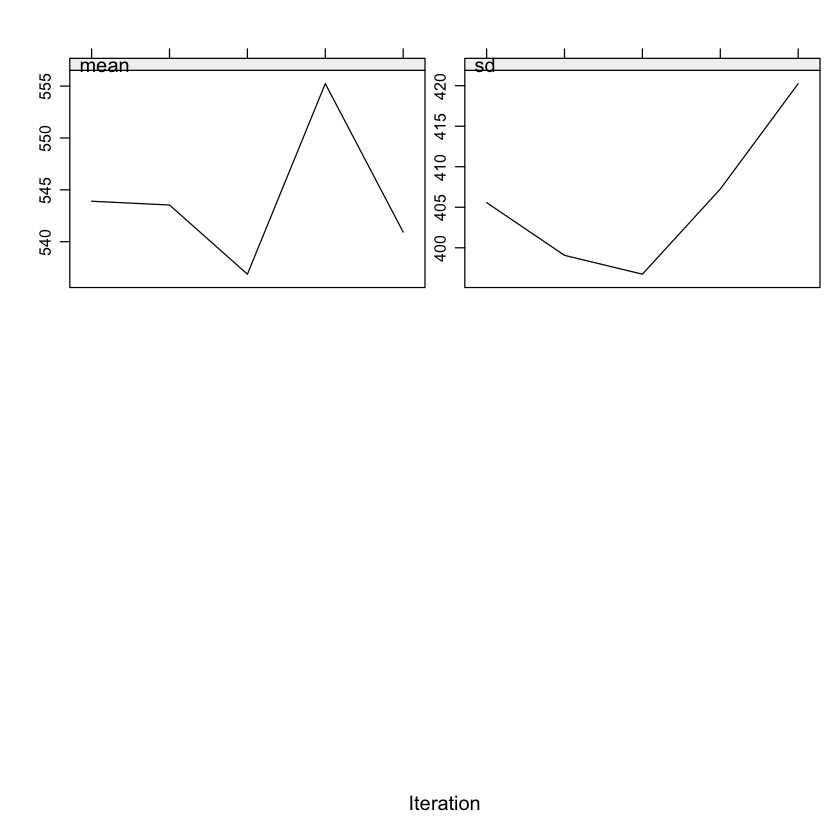

In [7]:
library(mice)

# Impute missing values with MICE
mice_mod <- mice(housing[, c("total_bedrooms", "longitude", "latitude", "housing_median_age", 
                             "total_rooms", "population", "households", 
                             "median_income", "median_house_value")], method="pmm", m=1, maxit=5)

completed_data <- complete(mice_mod)

# Replace original with imputed
housing$total_bedrooms <- completed_data$total_bedrooms

# Plot the imputation
mice_plot <- plot(mice_mod)
mice_plot

In [8]:
# Check for missing data
colSums(is.na(housing))

longitude           latitude housing_median_age        total_rooms 
                 0                  0                  0                  0 
    total_bedrooms         population         households      median_income 
                 0                  0                  0                  0 
median_house_value    ocean_proximity 
                 0                  0

In [9]:
# Summary statistics
summary_stats <- summary(housing)
summary_stats

   longitude         latitude     housing_median_age  total_rooms   
 Min.   :-124.3   Min.   :32.54   Min.   : 1.00      Min.   :    2  
 1st Qu.:-121.8   1st Qu.:33.93   1st Qu.:18.00      1st Qu.: 1448  
 Median :-118.5   Median :34.26   Median :29.00      Median : 2127  
 Mean   :-119.6   Mean   :35.63   Mean   :28.64      Mean   : 2636  
 3rd Qu.:-118.0   3rd Qu.:37.71   3rd Qu.:37.00      3rd Qu.: 3148  
 Max.   :-114.3   Max.   :41.95   Max.   :52.00      Max.   :39320  
 total_bedrooms     population      households     median_income    
 Min.   :   1.0   Min.   :    3   Min.   :   1.0   Min.   : 0.4999  
 1st Qu.: 296.0   1st Qu.:  787   1st Qu.: 280.0   1st Qu.: 2.5634  
 Median : 435.0   Median : 1166   Median : 409.0   Median : 3.5348  
 Mean   : 537.9   Mean   : 1425   Mean   : 499.5   Mean   : 3.8707  
 3rd Qu.: 647.0   3rd Qu.: 1725   3rd Qu.: 605.0   3rd Qu.: 4.7432  
 Max.   :6445.0   Max.   :35682   Max.   :6082.0   Max.   :15.0001  
 median_house_value   ocean_proxim

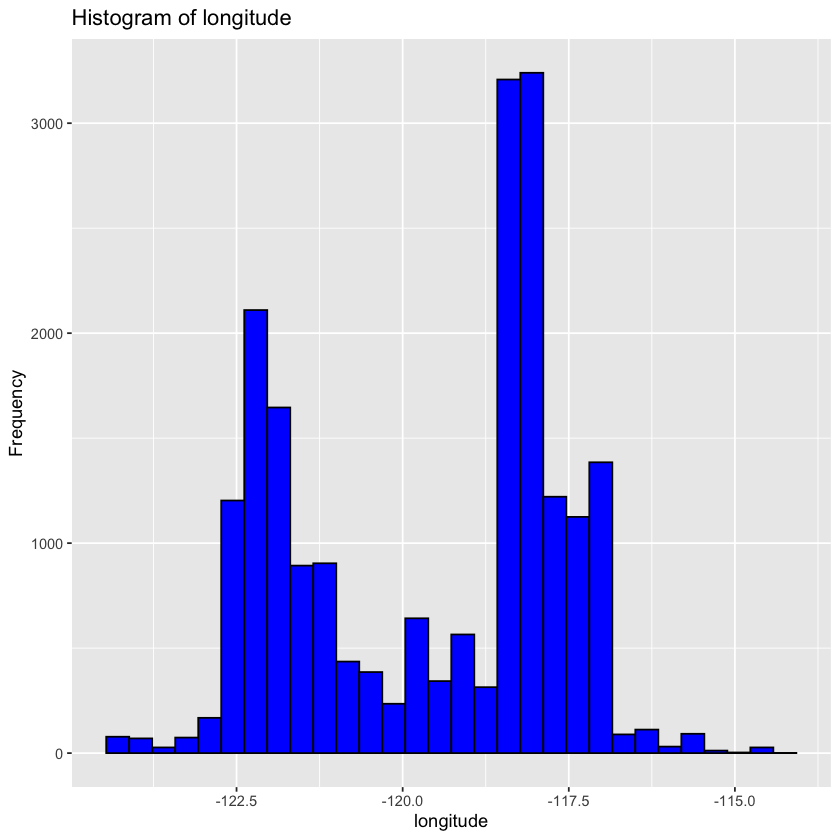

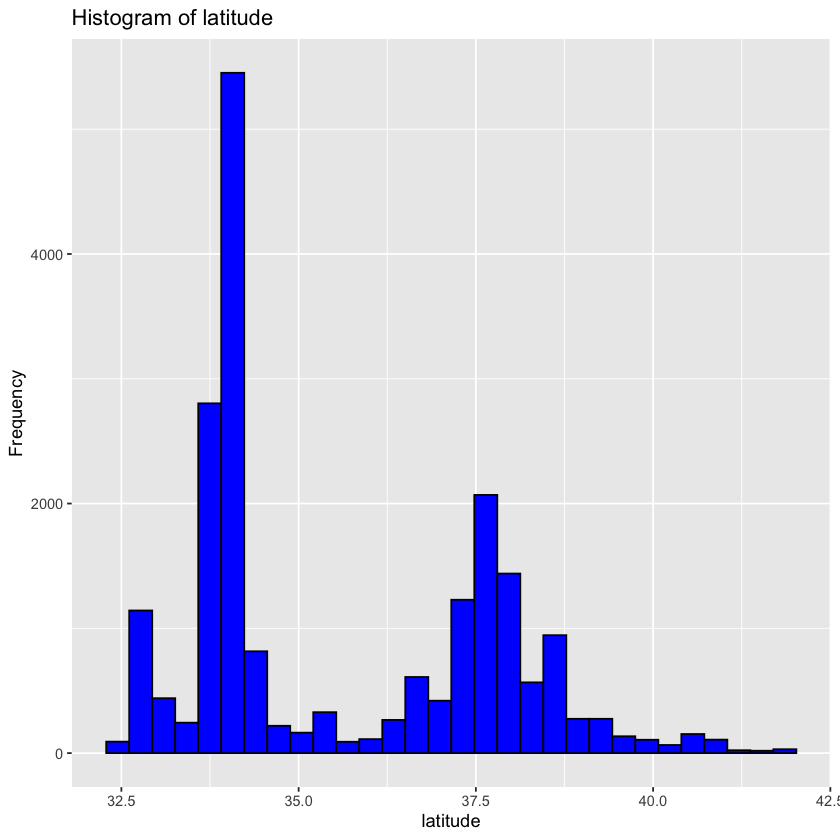

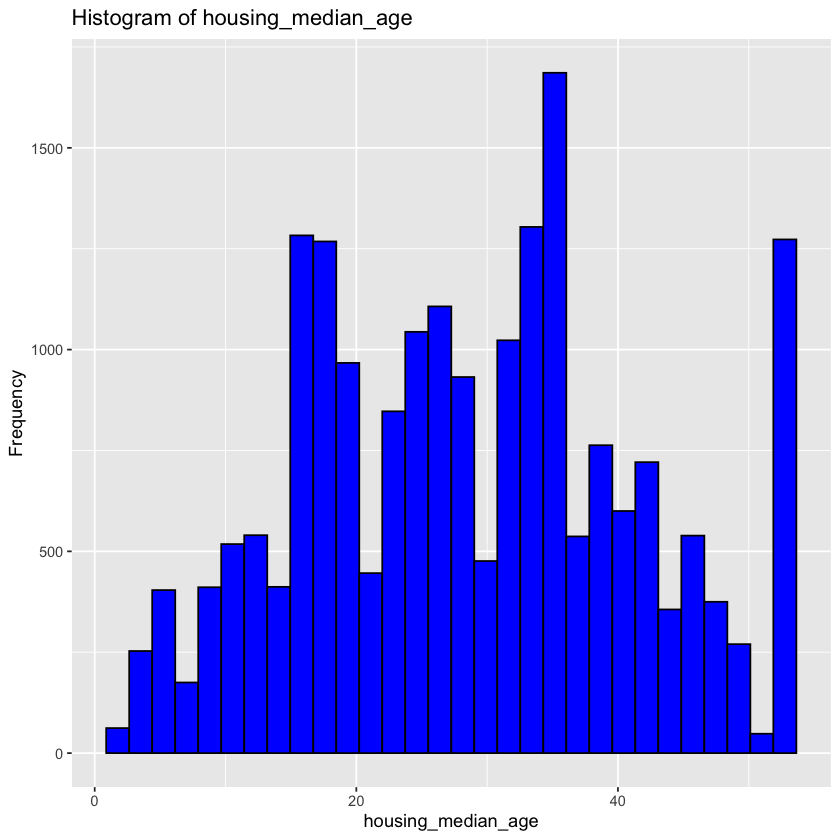

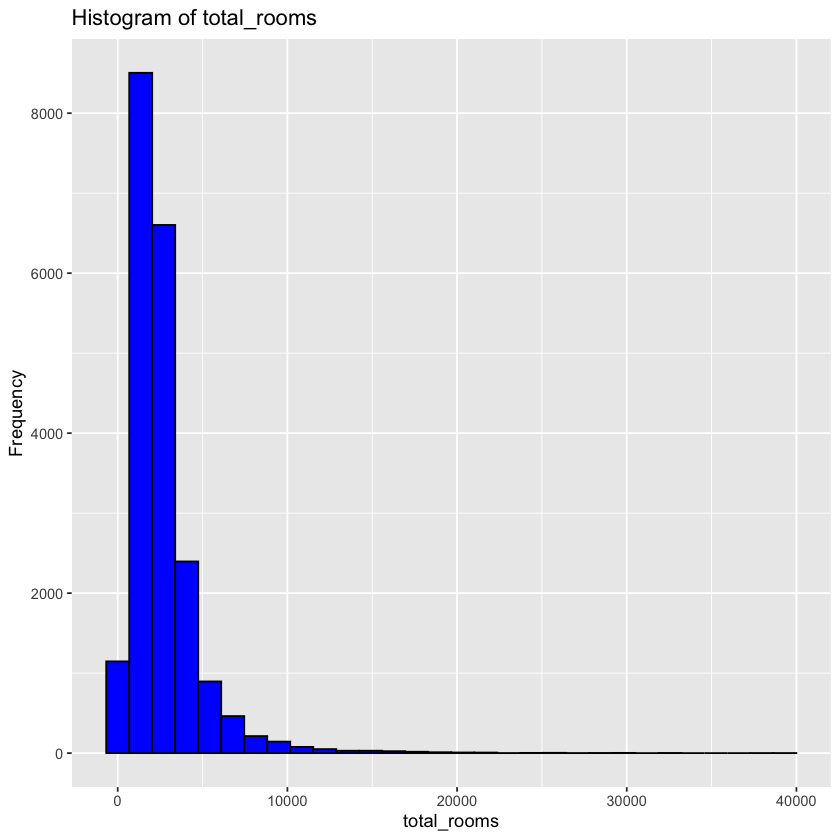

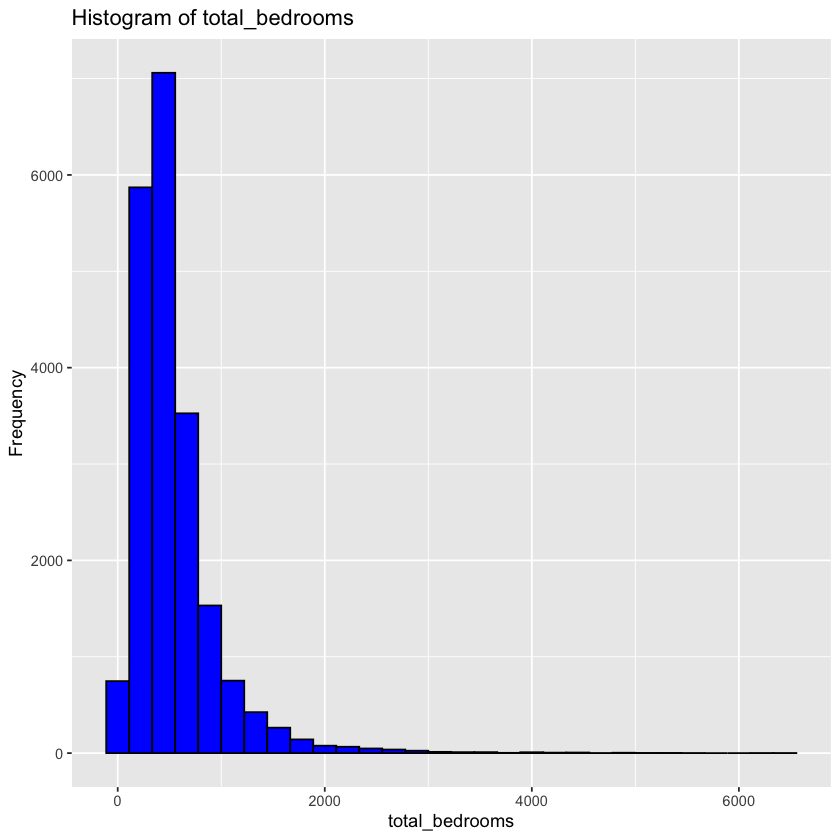

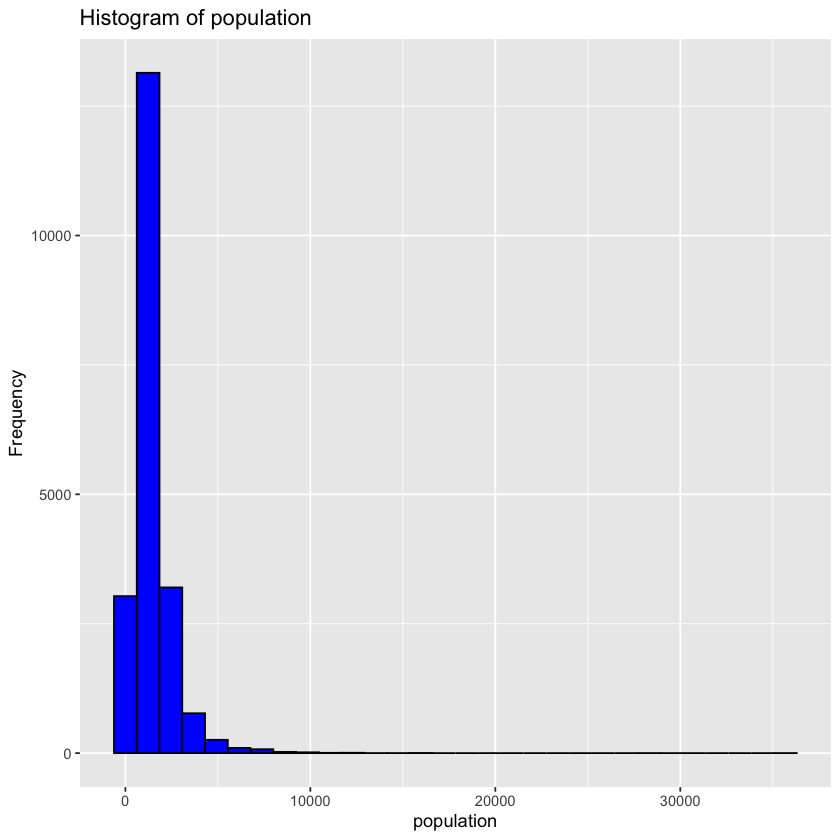

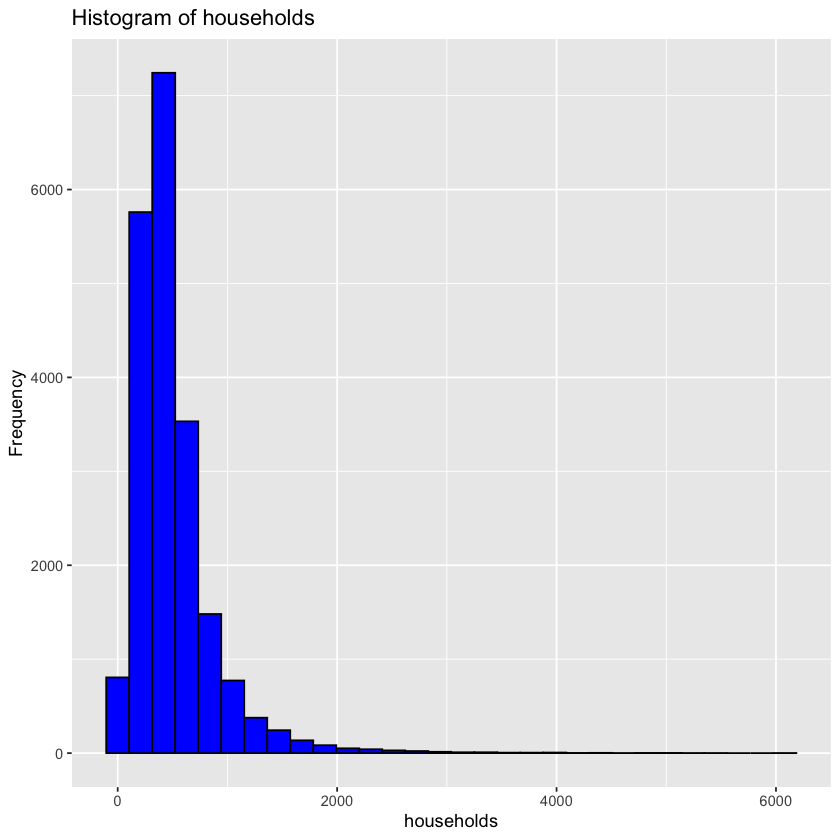

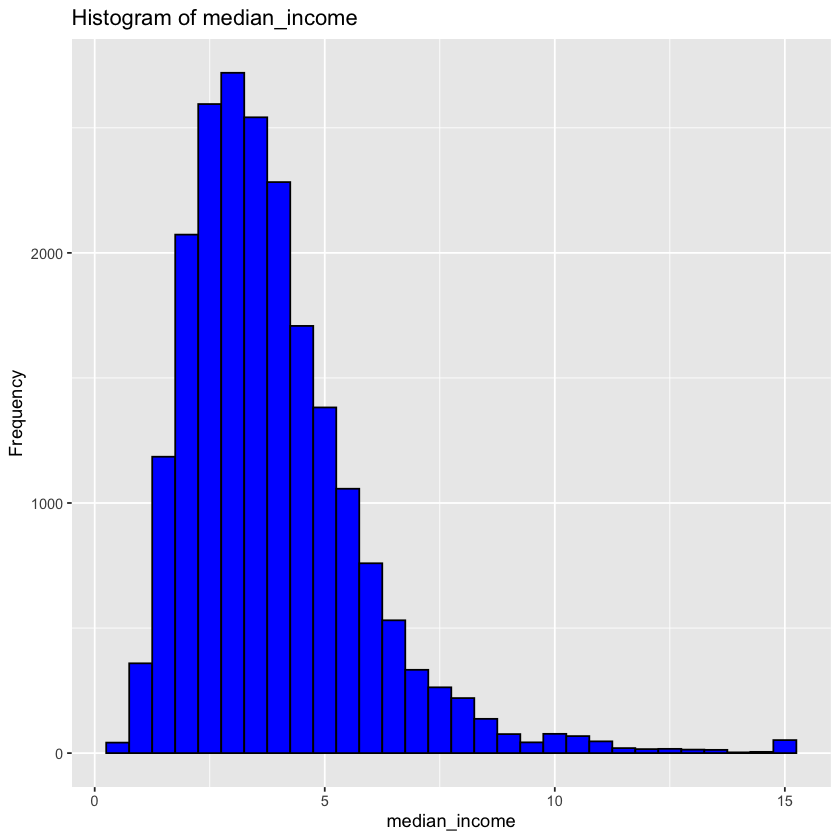

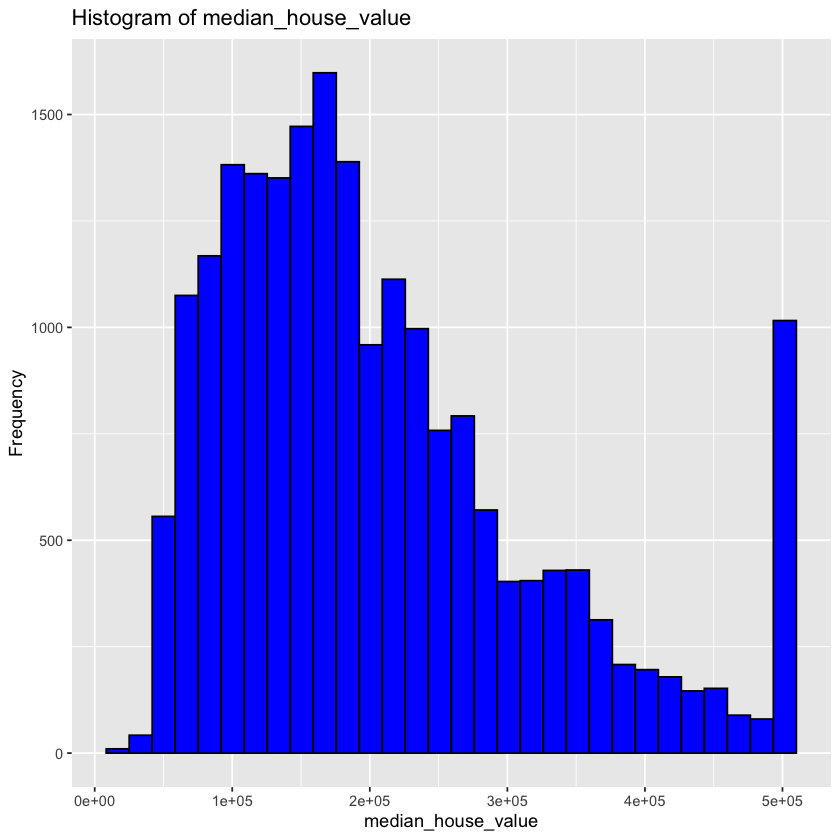

In [10]:
# Histograms
numeric_vars <- sapply(housing, is.numeric)

for (variable in names(housing)[numeric_vars]) {
  p <- ggplot(housing, aes(x = .data[[variable]])) +
       geom_histogram(bins = 30, fill = "blue", color = "black") +
       labs(title = paste("Histogram of", variable), x = variable, y = "Frequency")
  print(p)
}

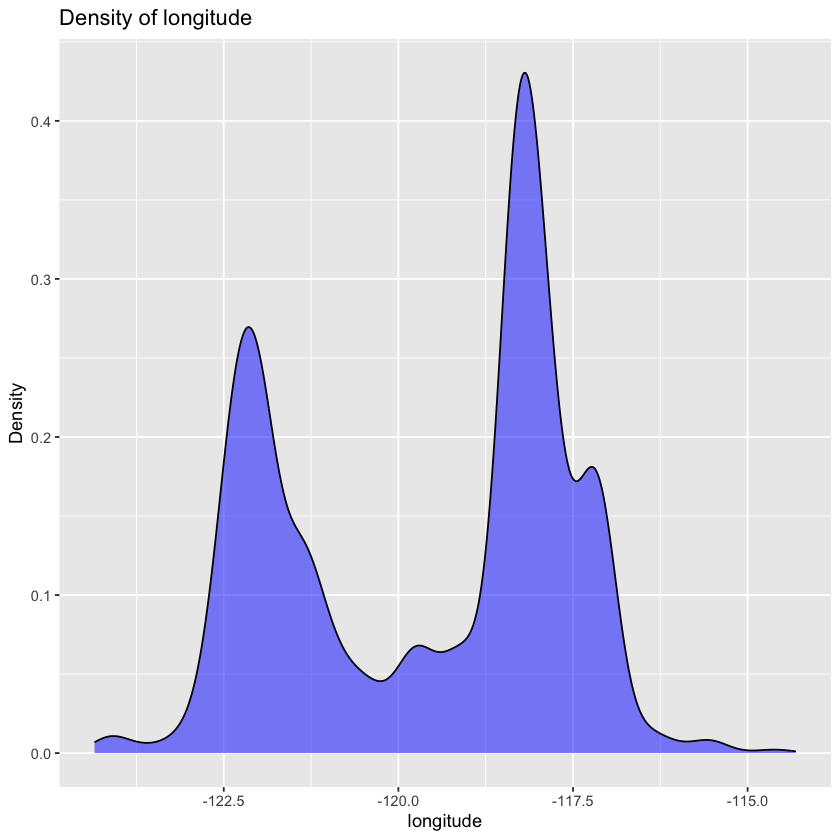

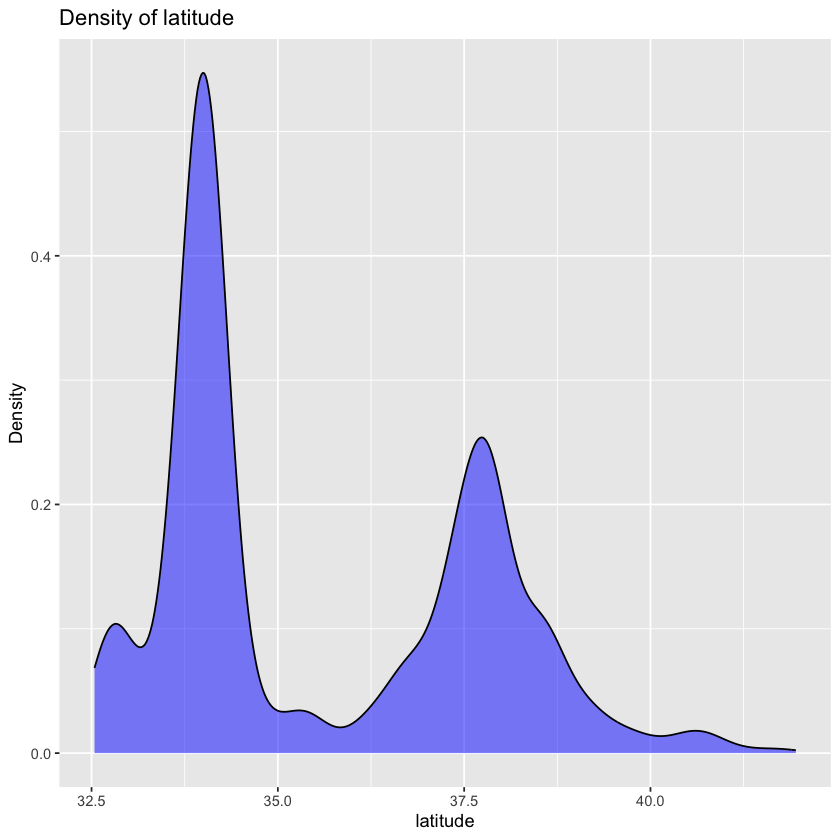

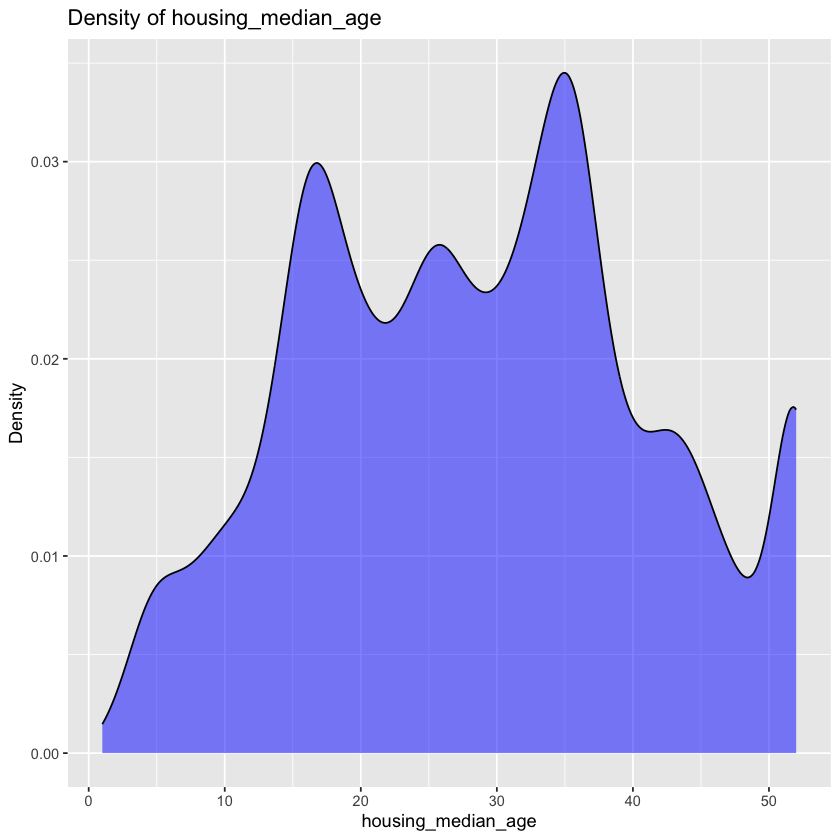

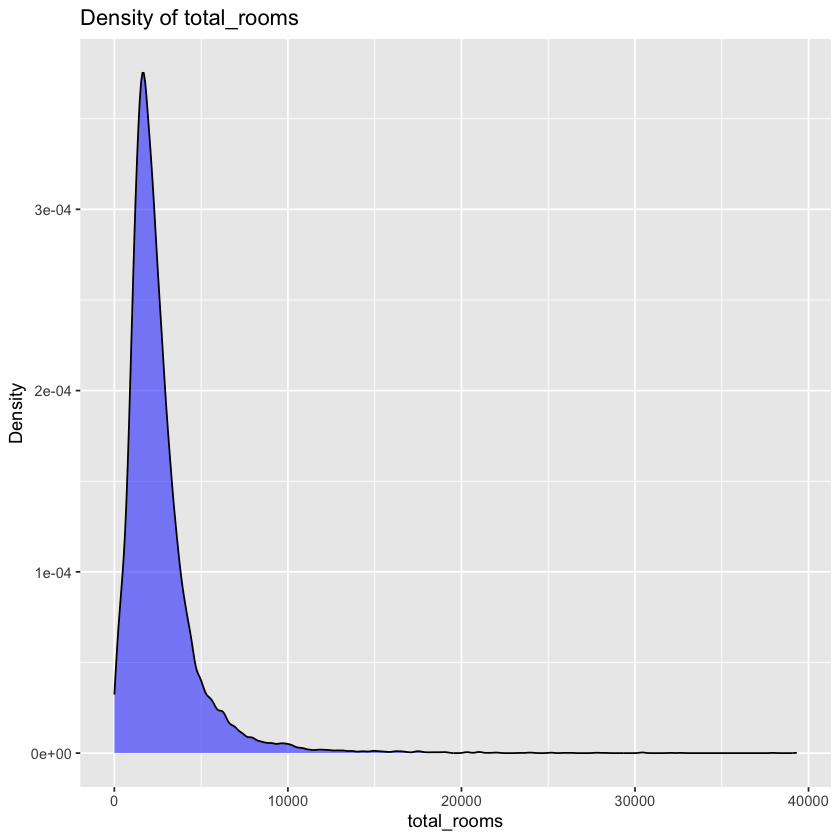

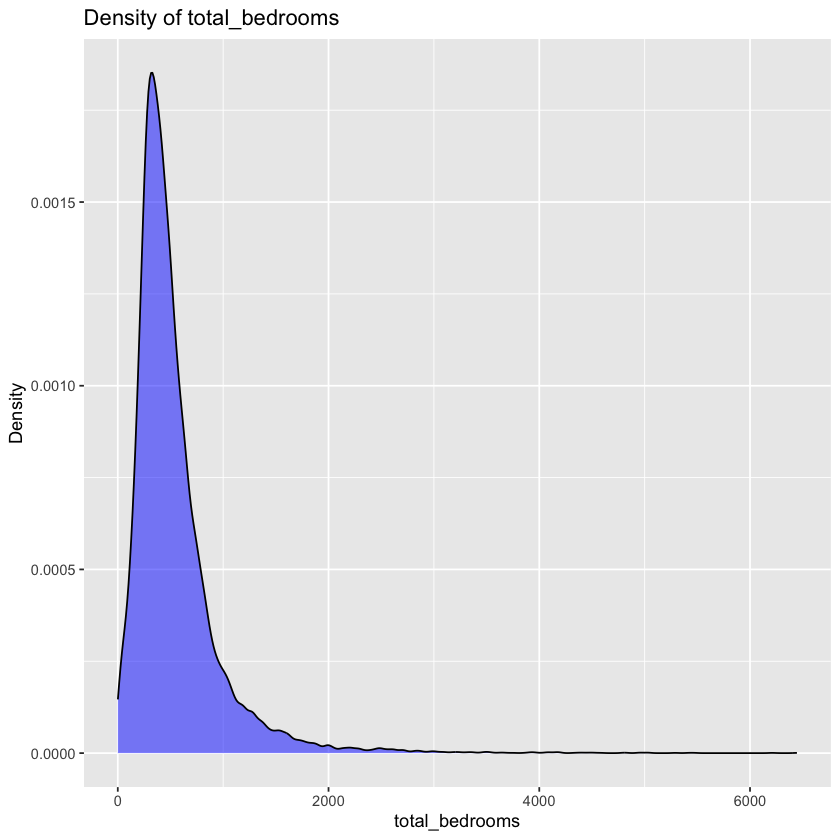

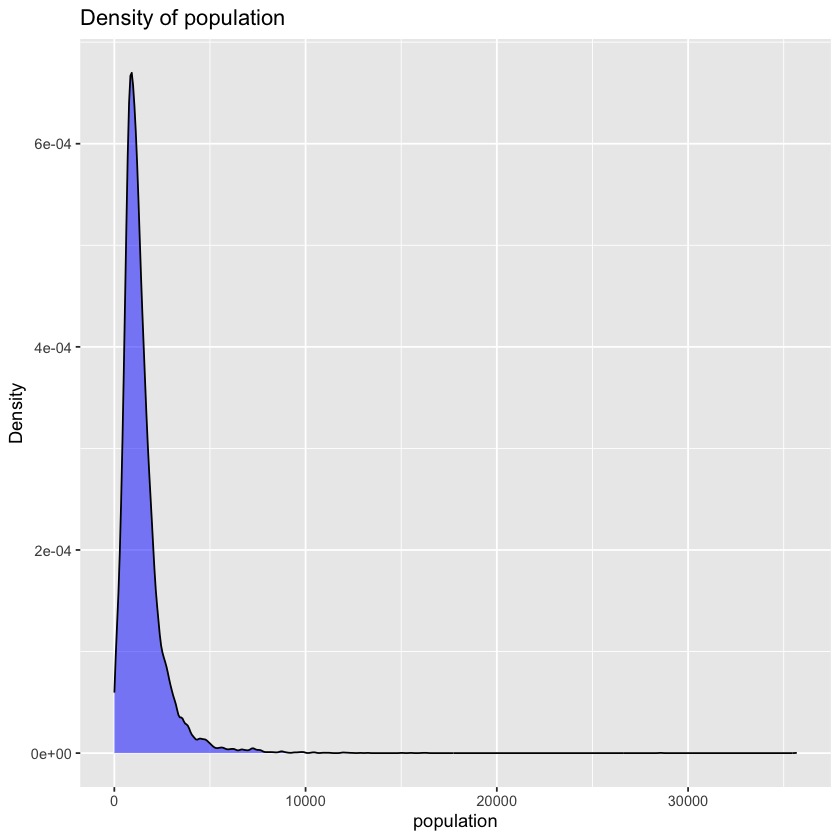

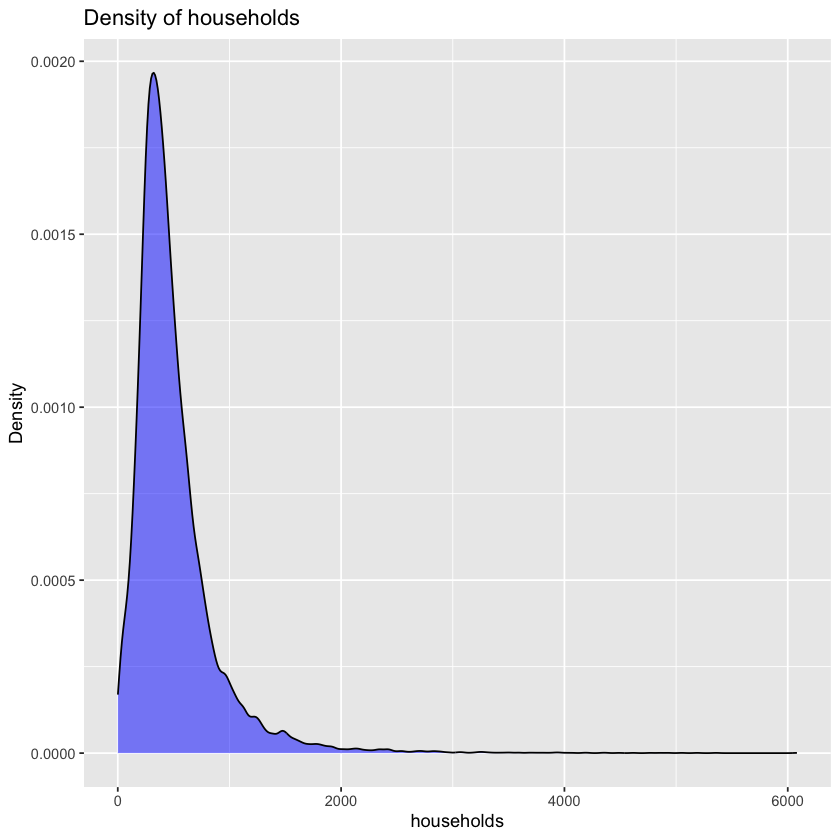

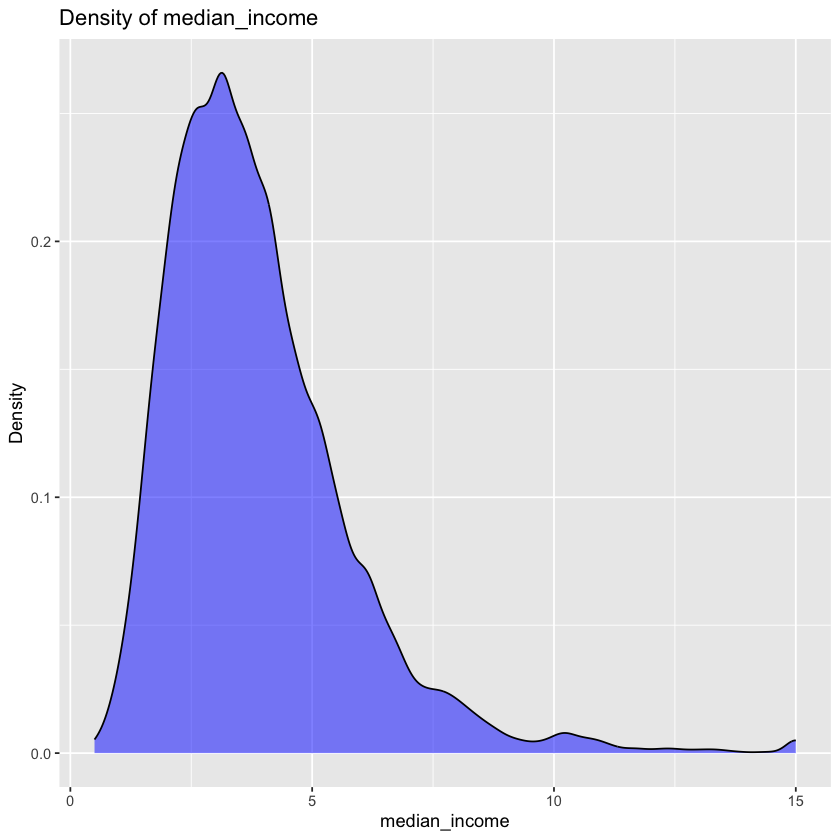

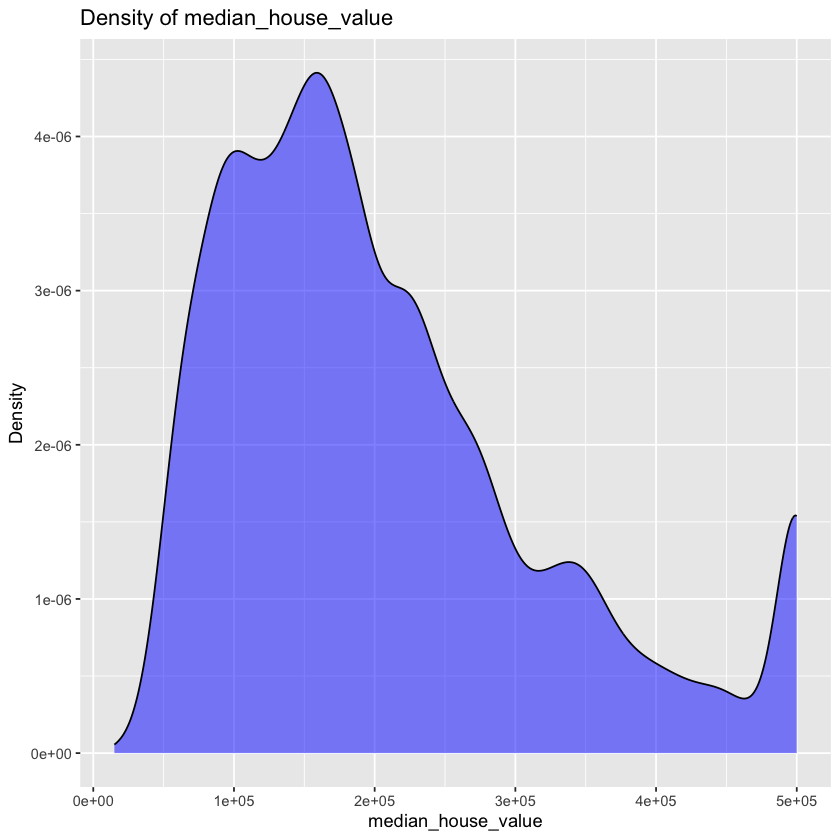

In [11]:
# Density plots
numeric_vars <- sapply(housing, is.numeric)

for (variable in names(housing)[numeric_vars]) {
  p <- ggplot(housing, aes(x = .data[[variable]])) +
       geom_density(fill = "blue", alpha = 0.5) +
       labs(title = paste("Density of", variable), x = variable, y = "Density")
  print(p)
}

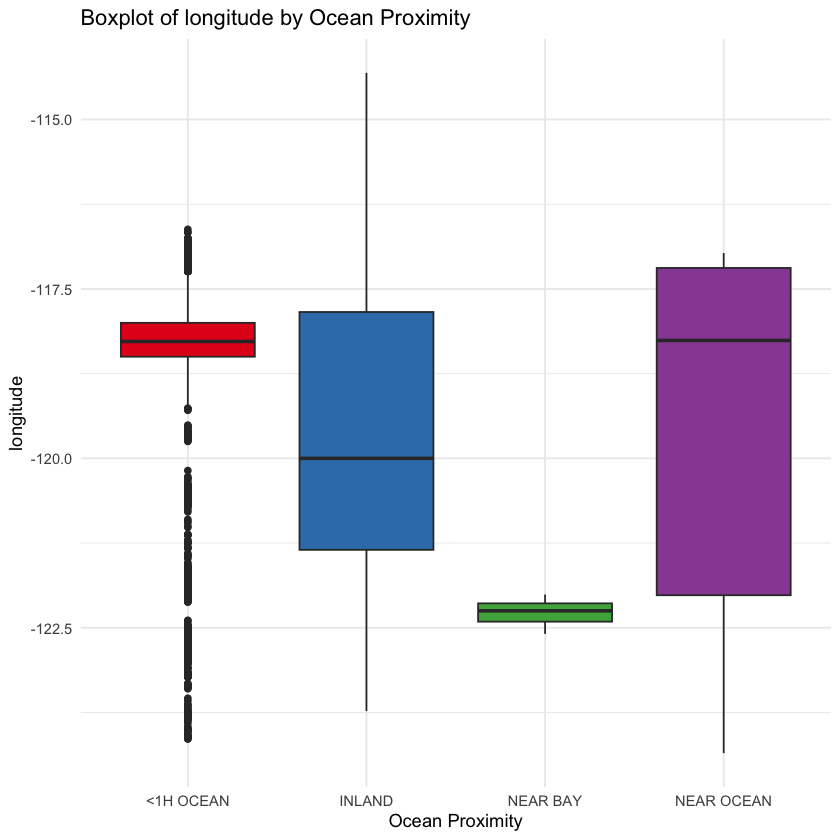

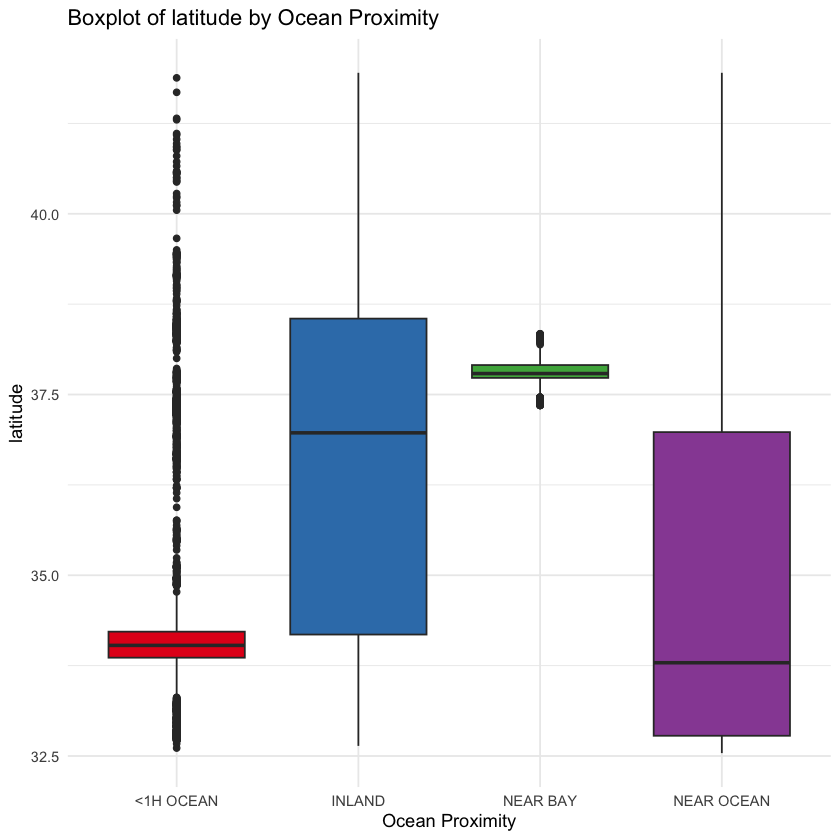

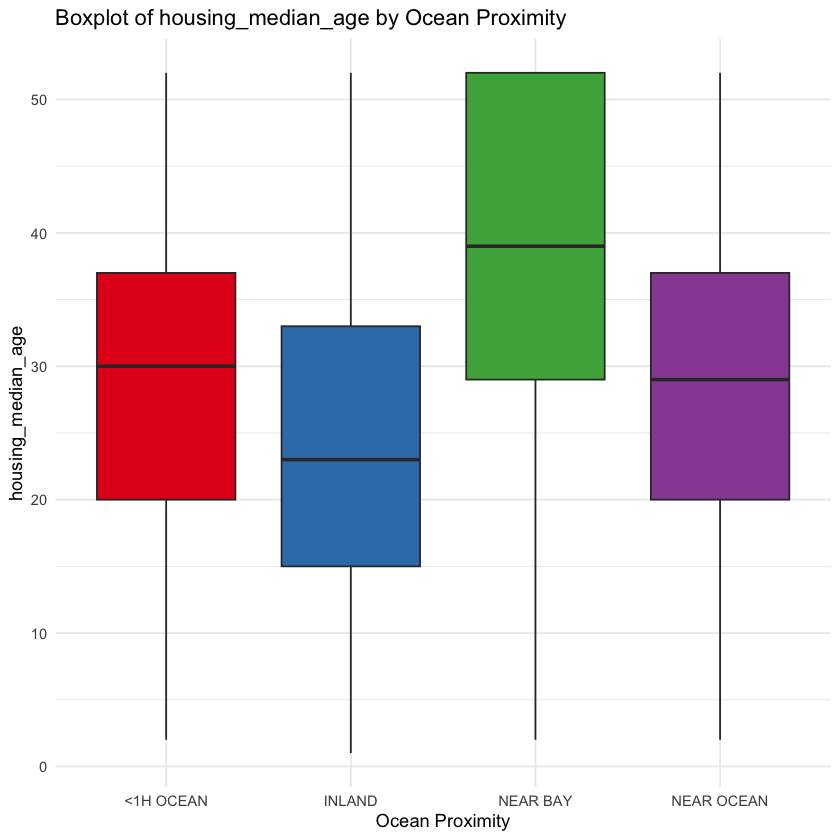

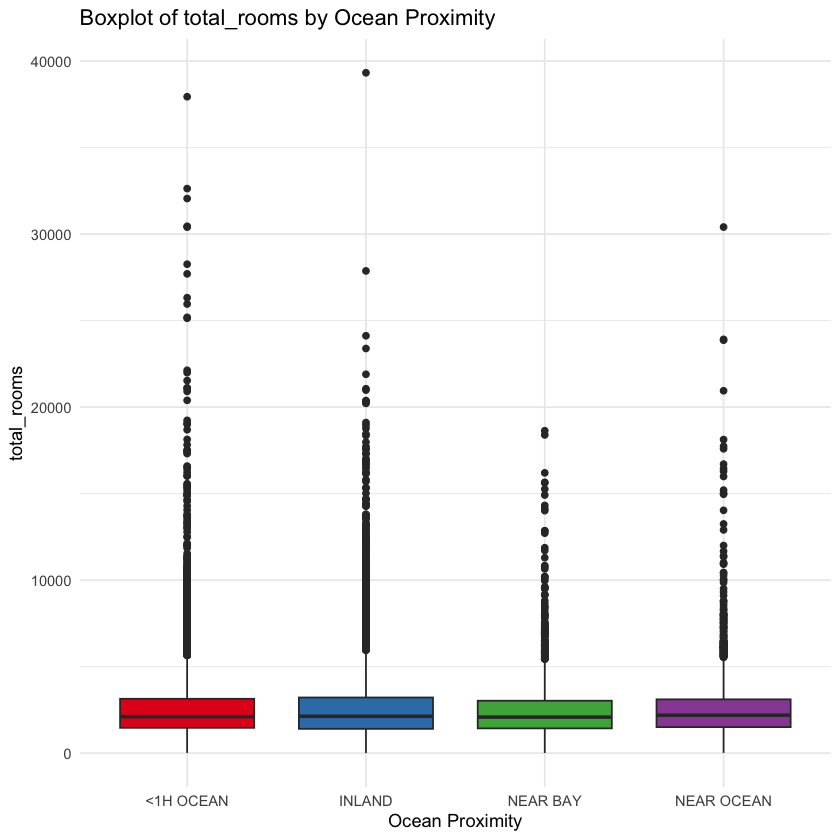

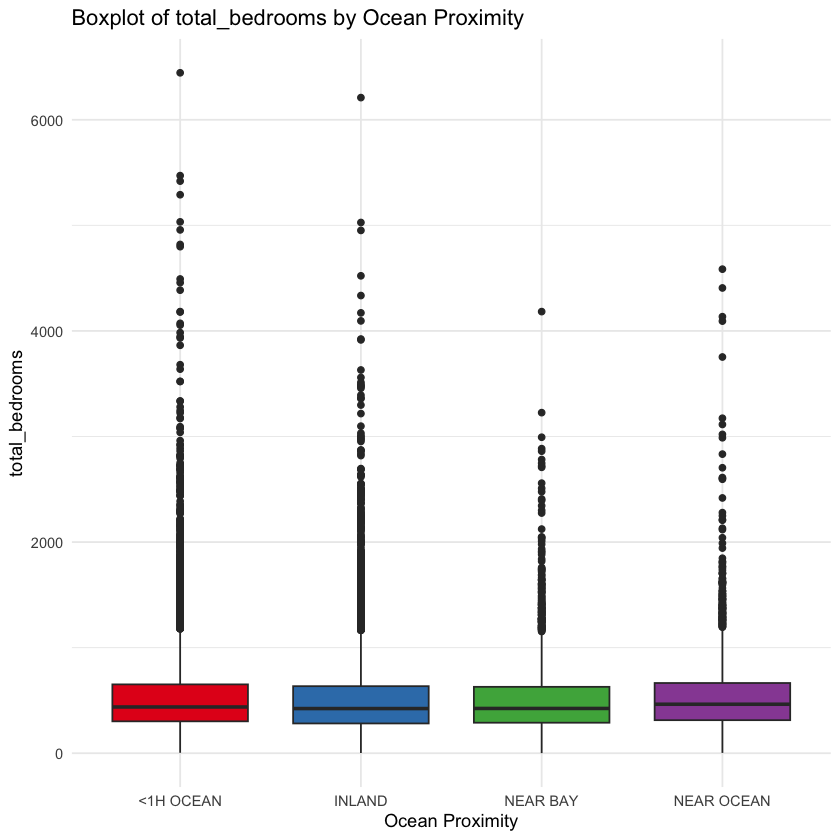

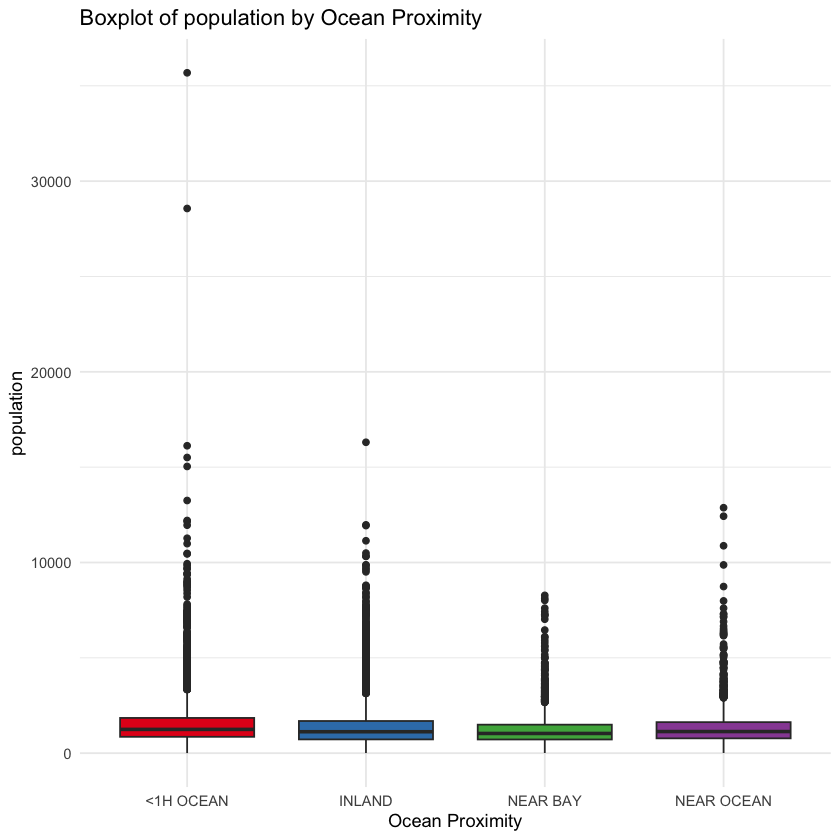

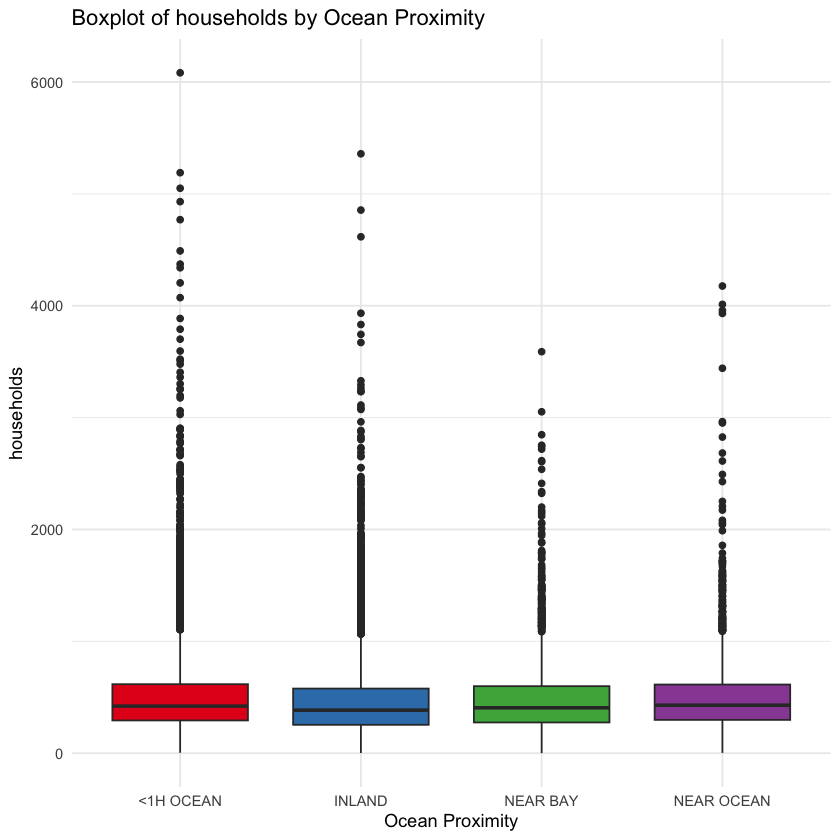

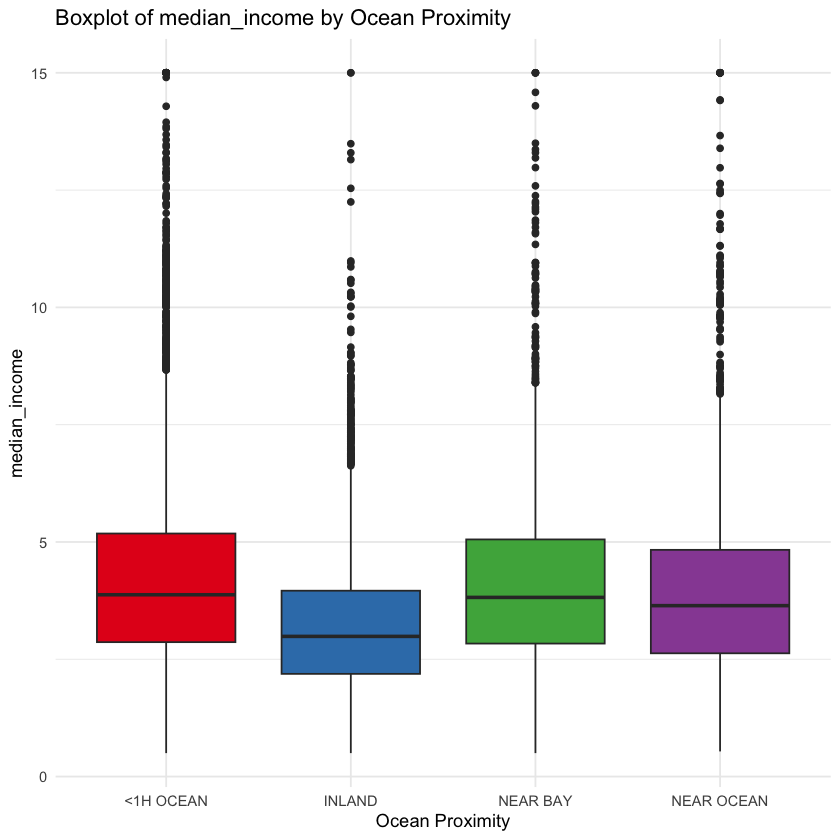

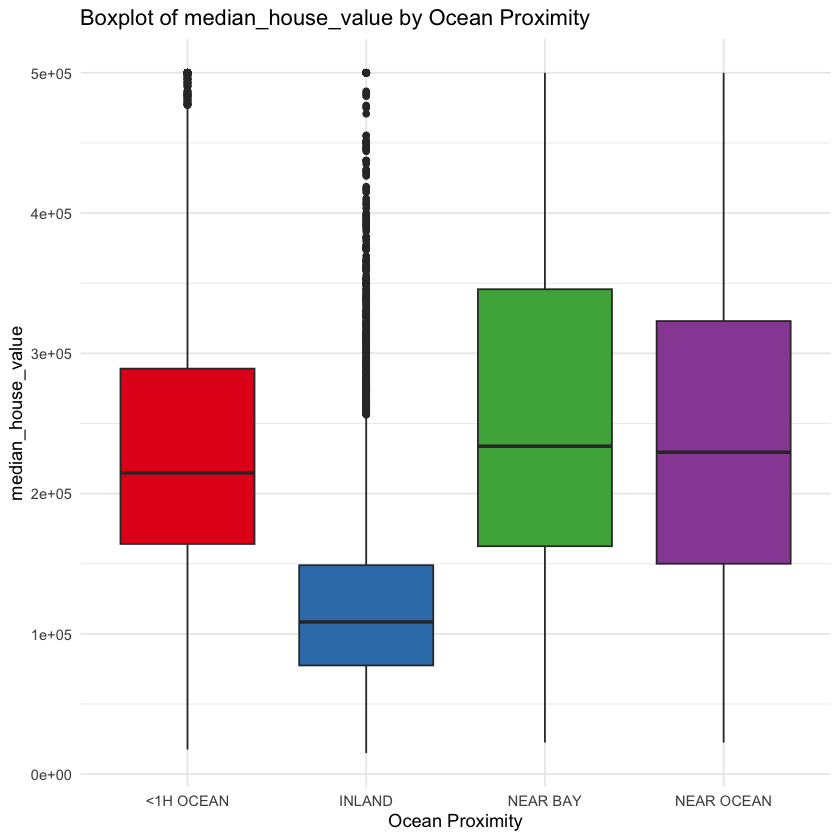

In [12]:
# Box plots
numeric_vars <- sapply(housing, is.numeric)

for (variable in names(housing)[numeric_vars]) {
  p <- ggplot(housing, aes(x = ocean_proximity, y = .data[[variable]], fill = ocean_proximity)) +
       geom_boxplot() +
       scale_fill_brewer(palette = "Set1") +  # Add a color palette
       labs(title = paste("Boxplot of", variable, "by Ocean Proximity"), 
            x = "Ocean Proximity", y = variable) +
       theme_minimal() +
       theme(legend.position = "none")  # Remove the legend
  print(p)
}

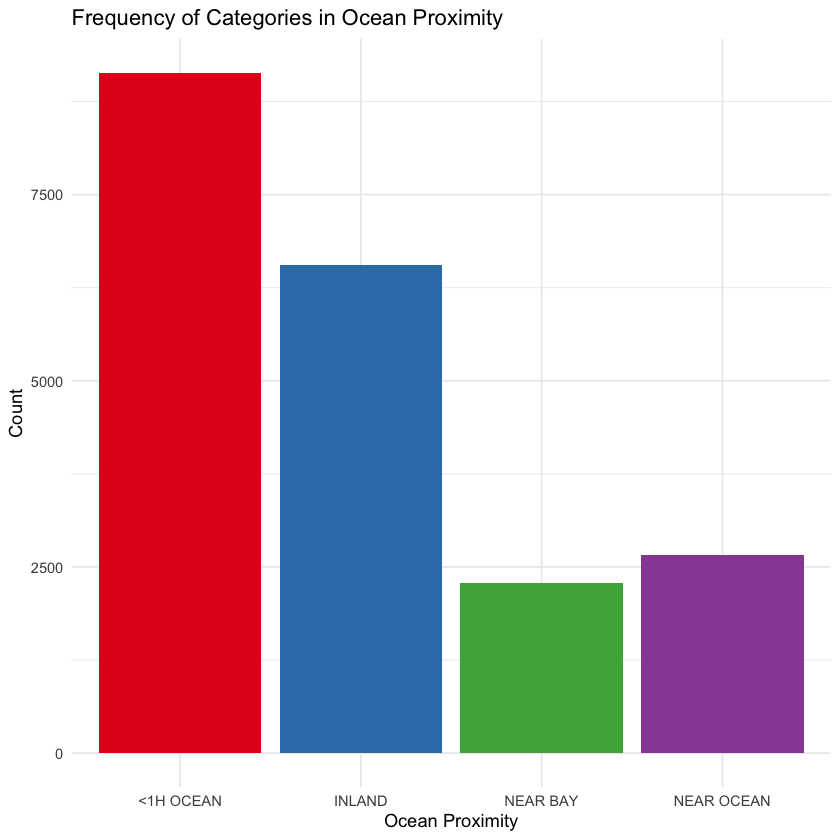

In [13]:
# Ocean proximity bar plot
ggplot(housing, aes(x = ocean_proximity, fill = ocean_proximity)) +
  geom_bar() + 
  scale_fill_brewer(palette = "Set1") +  # Add a color palette
  labs(title = "Frequency of Categories in Ocean Proximity",
       x = "Ocean Proximity", y = "Count") +
  theme_minimal() +
  theme(legend.position = "none")  # Remove the legend

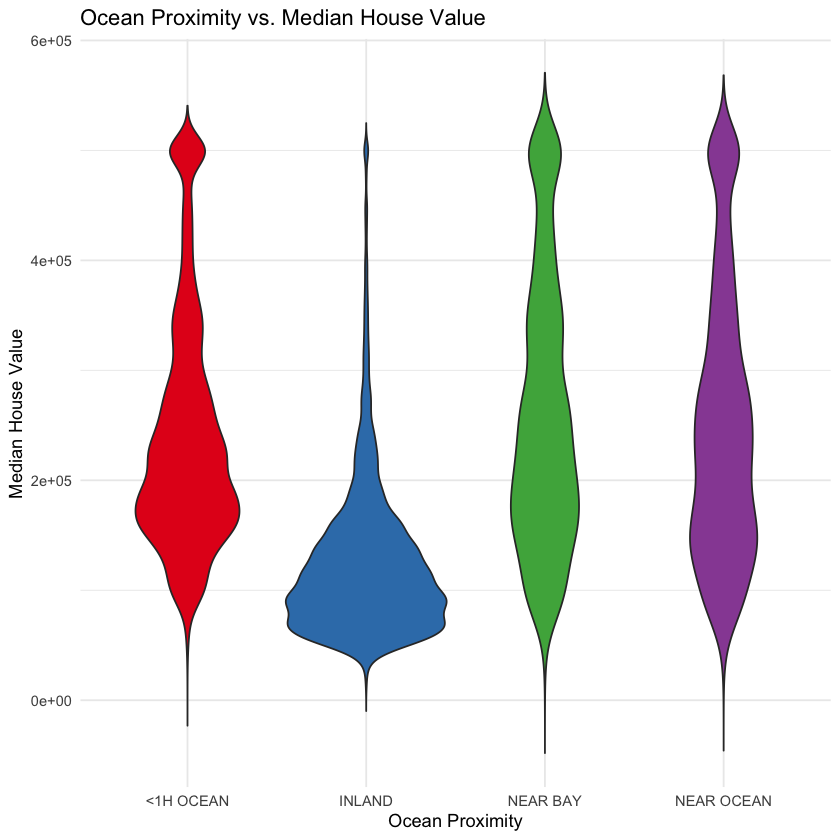

In [14]:
# Violin plot
ggplot(housing, aes(x = ocean_proximity, y = median_house_value, fill = ocean_proximity)) +
  geom_violin(trim = FALSE) +
  scale_fill_brewer(palette = "Set1") +  # Add a color palette
  labs(title = "Ocean Proximity vs. Median House Value",
       x = "Ocean Proximity", y = "Median House Value") +
  theme_minimal() +
  theme(legend.position = "none")  # Remove the legend

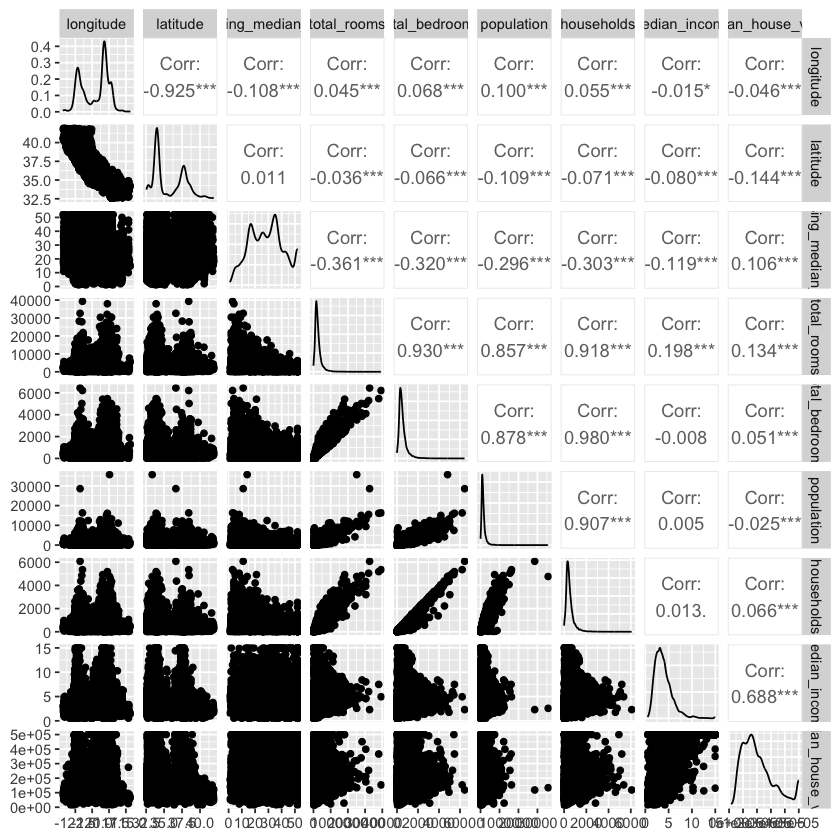

In [15]:
# Pair plots
numeric_vars <- housing[, sapply(housing, is.numeric)]
ggpairs(numeric_vars)

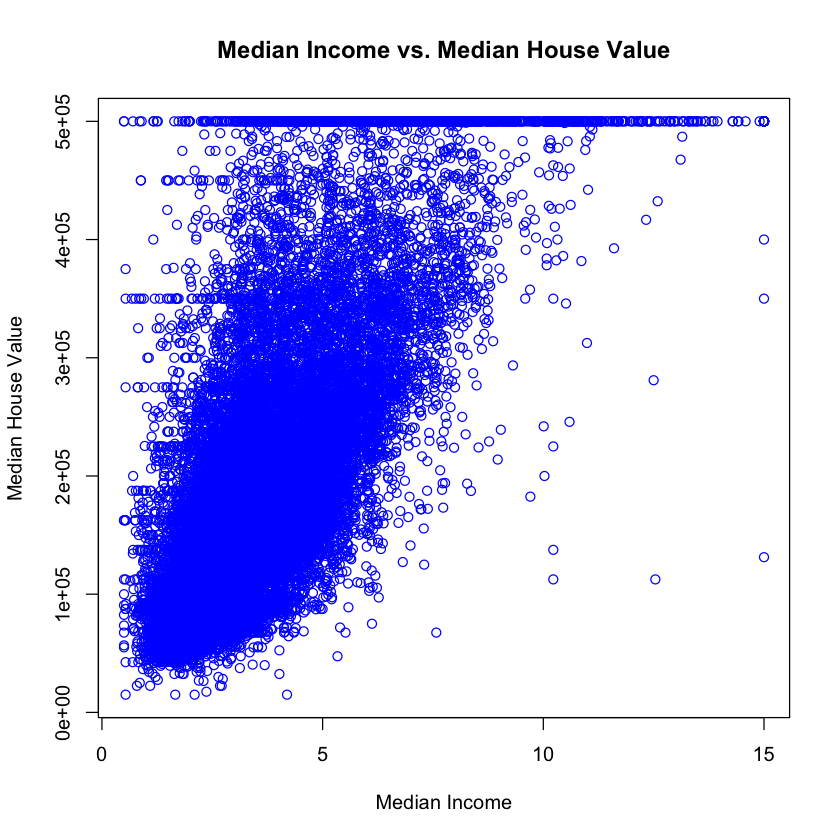

In [16]:
# Scatter plot
plot(housing$median_income, housing$median_house_value,
     xlab = "Median Income", ylab = "Median House Value",
     main = "Median Income vs. Median House Value",
     col = "blue")

In [17]:
# Correlation matrix
correlation_matrix <- cor(housing[, sapply(housing, is.numeric)])
correlation_matrix

longitude   latitude    housing_median_age total_rooms
longitude           1.00000000 -0.92466443 -0.10819681         0.04456798
latitude           -0.92466443  1.00000000  0.01117267        -0.03609960
housing_median_age -0.10819681  0.01117267  1.00000000        -0.36126220
total_rooms         0.04456798 -0.03609960 -0.36126220         1.00000000
total_bedrooms      0.06832834 -0.06620724 -0.32049830         0.92986102
population          0.09977322 -0.10878475 -0.29624424         0.85712597
households          0.05531009 -0.07103543 -0.30291601         0.91848449
median_income      -0.01517587 -0.07980913 -0.11903399         0.19804965
median_house_value -0.04596662 -0.14416028  0.10562341         0.13415311
                   total_bedrooms population   households  median_income
longitude           0.068328344    0.099773223  0.05531009 -0.015175865 
latitude           -0.066207237   -0.108784747 -0.07103543 -0.079809127 
housing_median_age -0.320498295   -0.296244240 -0.30291601 -0.119033990 
total_rooms         0.929861021    0.857125973  0.91848449  0.198049645 
total_bedrooms      1.000000000    0.877789857  0.97980467 -0.008021944 
population          0.877789857    1.000000000  0.90722227  0.004834346 
households          0.979804670    0.907222266  1.00000000  0.013033052 
median_income      -0.008021944    0.004834346  0.01303305  1.000000000 
median_house_value  0.050786683   -0.024649679  0.06584265  0.688075208 
                   median_house_value
longitude          -0.04596662       
latitude           -0.14416028       
housing_median_age  0.10562341       
total_rooms         0.13415311       
total_bedrooms      0.05078668       
population         -0.02464968       
households          0.06584265       
median_income       0.68807521       
median_house_value  1.00000000

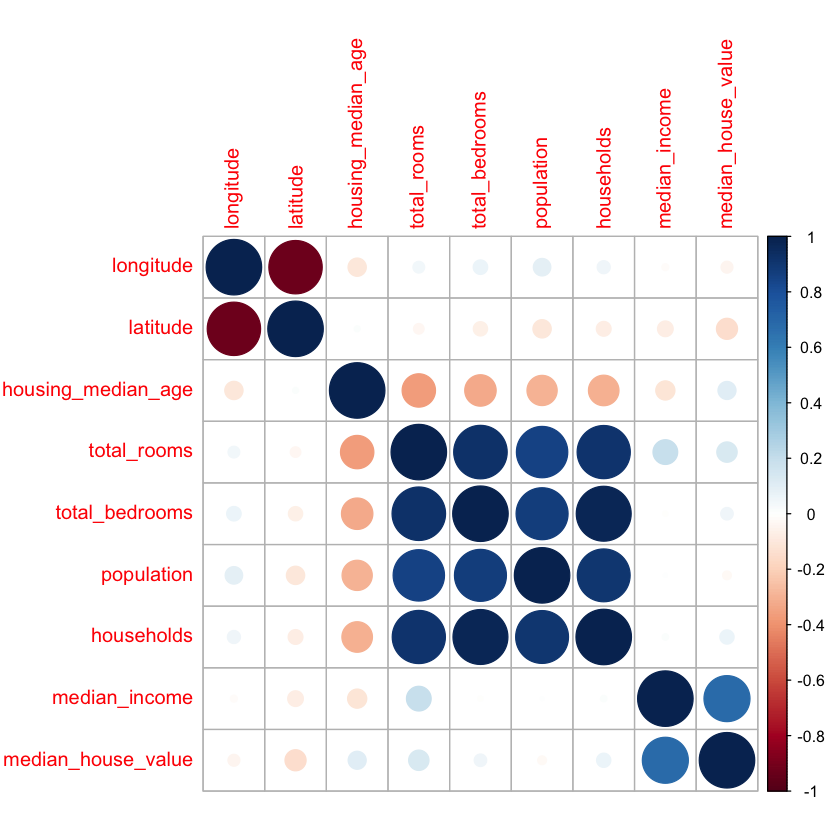

In [18]:
# Visualize correlation matrix
corrplot(correlation_matrix, method = "circle")

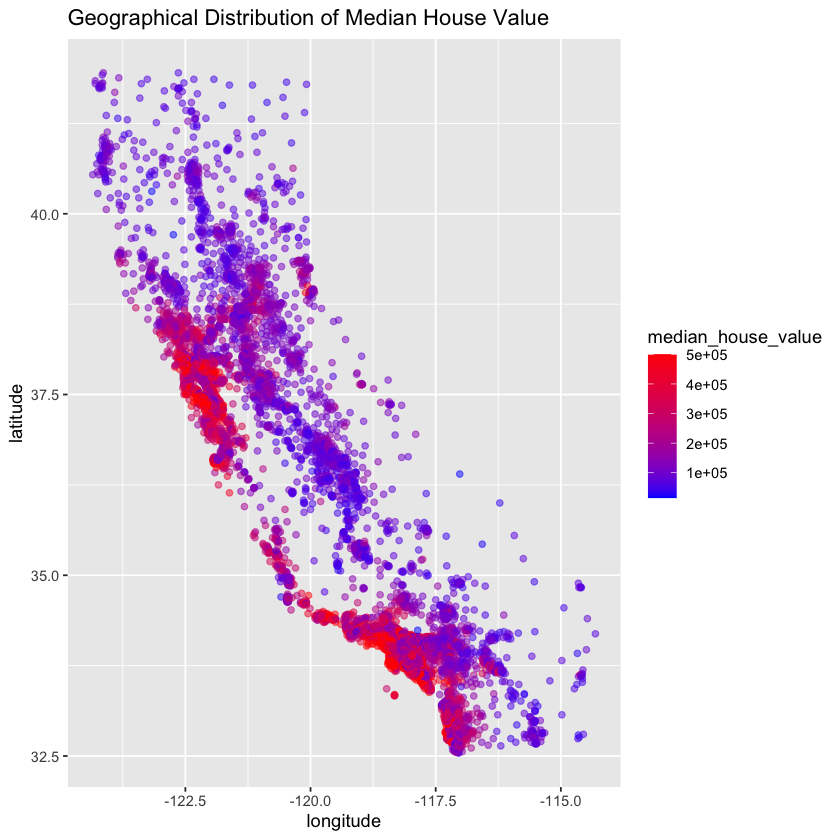

In [19]:
# Geographical plot
ggplot(housing, aes(x = longitude, y = latitude, color = median_house_value)) +
  geom_point(alpha = 0.5) +
  scale_color_gradient(low = "blue", high = "red") +
  labs(title = "Geographical Distribution of Median House Value")

In [20]:
# Examine VIF
lm_model <- lm(median_house_value ~ . - ocean_proximity, data = housing)

vif_result <- vif(lm_model)

# Convert to DataFrame
vif_dataframe <- data.frame(
  Variable = names(vif_result),
  VIF = vif_result
)

# Sort the DataFrame
vif_dataframe_sorted <- vif_dataframe[order(-vif_dataframe$VIF), ]
vif_dataframe_sorted

Variable           VIF      
total_bedrooms     total_bedrooms     36.067278
households         households         35.296552
total_rooms        total_rooms        12.617091
latitude           latitude            8.829453
longitude          longitude           8.713764
population         population          6.382911
median_income      median_income       1.729025
housing_median_age housing_median_age  1.260112

# Feature Engineering

In [21]:
# Feature engineering
housing$rooms_per_household <- housing$total_rooms / housing$households
housing$bedrooms_per_room <- housing$total_bedrooms / housing$total_rooms
housing$log_median_income <- log(housing$median_income)
str(housing)

'data.frame':	20640 obs. of  13 variables:
 $ longitude          : num  -122 -122 -122 -122 -122 ...
 $ latitude           : num  37.9 37.9 37.9 37.9 37.9 ...
 $ housing_median_age : num  41 21 52 52 52 52 52 52 42 52 ...
 $ total_rooms        : num  880 7099 1467 1274 1627 ...
 $ total_bedrooms     : num  129 1106 190 235 280 ...
 $ population         : num  322 2401 496 558 565 ...
 $ households         : num  126 1138 177 219 259 ...
 $ median_income      : num  8.33 8.3 7.26 5.64 3.85 ...
 $ median_house_value : num  452600 358500 352100 341300 342200 ...
 $ ocean_proximity    : Factor w/ 4 levels "<1H OCEAN","INLAND",..: 3 3 3 3 3 3 3 3 3 3 ...
 $ rooms_per_household: num  6.98 6.24 8.29 5.82 6.28 ...
 $ bedrooms_per_room  : num  0.147 0.156 0.13 0.184 0.172 ...
 $ log_median_income  : num  2.12 2.12 1.98 1.73 1.35 ...


# Splitting the Data

In [22]:
# Set seed for reproducibility
set.seed(123)

# Create stratified partition for training data
trainIndex <- createDataPartition(housing$ocean_proximity, p = 0.85, list = FALSE)

# Extract training data
train_temp <- housing[trainIndex, ]

# Remaining data for splitting into validation and test
remaining <- housing[-trainIndex, ]

# Split the remaining data into validation and test
validationIndex <- createDataPartition(remaining$ocean_proximity, p = 0.5, list = FALSE)

# Extract validation and test datasets
validation_data <- remaining[validationIndex, ]
test_data <- remaining[-validationIndex, ]

# Split the temporary training set into final training and validation
trainIndexFinal <- createDataPartition(train_temp$ocean_proximity, p = (0.7/0.85), list = FALSE)
train_data <- train_temp[trainIndexFinal, ]
val_data <- train_temp[-trainIndexFinal, ]

# Preprocessing Recipes

In [23]:
# General recipe without dummy encoding
general_recipe <- recipe(median_house_value ~ ., data = train_data) %>%
  step_normalize(all_predictors(), -all_nominal())

# Recipe with dummy encoding
dummy_recipe <- recipe(median_house_value ~ ., data = train_data) %>%
  step_normalize(all_predictors(), -all_nominal()) %>%
  step_dummy(all_nominal(), -all_outcomes())

In [24]:
# View the results of the recipe
dummy_recipe_prepped <- prep(dummy_recipe)
transformed_data <- juice(dummy_recipe_prepped)
head(transformed_data)

longitude latitude housing_median_age total_rooms total_bedrooms population
1 -1.321902 1.051554  0.988447          -0.8075199  -0.9771971     -0.9793979
2 -1.316925 1.042188 -0.602270           2.0280961   1.3456919      0.8549779
3 -1.326878 1.037504  1.863341          -0.5398713  -0.8321651     -0.8258715
4 -1.331855 1.037504  1.863341          -0.6278716  -0.7251743     -0.7711667
5 -1.331855 1.037504  1.863341          -0.4669177  -0.6181835     -0.7649903
6 -1.331855 1.037504  1.863341          -0.7897374  -0.7774809     -0.8991053
  households median_income rooms_per_household bedrooms_per_room
1 -0.9860768  2.31612195    0.6341869          -1.1324314       
2  1.6734356  2.30372432    0.3285258          -0.9755173       
3 -0.8520499  1.75989542    1.1684900          -1.4234789       
4 -0.7416749  0.91899218    0.1561136          -0.4869666       
5 -0.6365559 -0.01702903    0.3464381          -0.6976901       
6 -0.8100023  0.08225621   -0.2764451           0.3195388       
  log_median_income median_house_value ocean_proximity_INLAND
1 1.8515759         452600             0                     
2 1.8455085         358500             0                     
3 1.5606646         352100             0                     
4 1.0274653         341300             0                     
5 0.2150229         342200             0                     
6 0.3175280         269700             0                     
  ocean_proximity_NEAR.BAY ocean_proximity_NEAR.OCEAN
1 1                        0                         
2 1                        0                         
3 1                        0                         
4 1                        0                         
5 1                        0                         
6 1                        0

# Specifying the Models

In [25]:
# Linear Regression
linear_spec <- linear_reg() %>%
  set_engine("lm")

# XGBoost
xgb_spec <- boost_tree(
  trees = tune(),
  tree_depth = tune(),
  min_n = tune(),
  loss_reduction = tune(),
  sample_size = tune(),
  learn_rate = tune()
) %>%
  set_engine("xgboost") %>%
  set_mode("regression")

# Random Forest
rf_spec <- rand_forest(
  trees = tune(),
  mtry = tune(),
  min_n = tune()
) %>%
  set_engine("ranger") %>%
  set_mode("regression")

# SVM
svm_spec <- svm_rbf(
  cost = tune(),
  rbf_sigma = tune()
) %>%
  set_engine("kernlab") %>%
  set_mode("regression")

# Ridge regression
ridge_spec <- linear_reg(
  penalty = tune(),
  mixture = 0
) %>%
  set_engine("glmnet")

# Lasso regression
lasso_spec <- linear_reg(
  penalty = tune(),
  mixture = 1
) %>%
  set_engine("glmnet")

# GAM
gam_model <- function(data) {
  gam(
    formula = median_house_value ~ s(longitude) + s(latitude) +
      s(total_bedrooms) + s(housing_median_age) +
      s(total_rooms) + s(population) +
      s(households) + s(median_income) +
      s(rooms_per_household) + s(bedrooms_per_room) +
      s(log_median_income) +
      ocean_proximity_INLAND + ocean_proximity_NEAR.BAY + 
      ocean_proximity_NEAR.OCEAN,
    data = data, 
    method = "REML"
  )
}

# Hyperparameter Tuning

In [26]:
# Cross-validation setup
set.seed(123)
cv_folds <- vfold_cv(train_data, v = 10, strata = median_house_value)

In [27]:
# Hyperparameter grid for XGBoost
xgb_grid <- grid_latin_hypercube(
  tree_depth(range = c(1, 10)),
  trees(range = c(100, 1000)),
  min_n(range = c(1, 10)),
  loss_reduction(range = c(0, 10)),
  sample_size(range = c(0, 1)),
  learn_rate(range = c(0.01, 0.3)),
  size = 30
)

# Hyperparameter grid for Random Forest
rf_grid <- grid_latin_hypercube(
  mtry(range = c(1, ceiling(sqrt(ncol(train_data))))),
  trees(range = c(500, 1500)),
  min_n(range = c(1, 10)),
  size = 30
)

# Hyperparameter grid for SVM
svm_grid <- grid_latin_hypercube(
  cost(range = c(0.1, 10)),
  rbf_sigma(range = c(0.1, 1)),
  size = 30
)

# Hyperparameter grid for Ridge Regression
ridge_grid <- grid_regular(
  penalty(range = c(10^(-10), 10^(-1))),
  levels = 30
)

# Hyperparameter grid for Lasso Regression
lasso_grid <- grid_regular(
  penalty(range = c(10^(-10), 10^(-1))),
  levels = 30
)

In [28]:
# Tuning XGBoost
xgb_wf <- workflow() %>%
  add_recipe(dummy_recipe) %>%
  add_model(xgb_spec)
xgb_res <- tune_grid(xgb_wf, resamples = cv_folds, grid = xgb_grid)

# Tuning Random Forest
rf_wf <- workflow() %>%
  add_recipe(dummy_recipe) %>%
  add_model(rf_spec)
rf_res <- tune_grid(rf_wf, resamples = cv_folds, grid = rf_grid)

# Tuning SVM
svm_wf <- workflow() %>%
  add_recipe(dummy_recipe) %>%
  add_model(svm_spec)
svm_res <- tune_grid(svm_wf, resamples = cv_folds, grid = svm_grid)

# Tuning Ridge Regression
ridge_wf <- workflow() %>%
  add_recipe(dummy_recipe) %>%
  add_model(ridge_spec)
ridge_res <- tune_grid(ridge_wf, resamples = cv_folds, grid = ridge_grid)

# Tuning Lasso Regression
lasso_wf <- workflow() %>%
  add_recipe(dummy_recipe) %>%
  add_model(lasso_spec)
lasso_res <- tune_grid(lasso_wf, resamples = cv_folds, grid = lasso_grid)

→ A | warning: A correlation computation is required, but `estimate` is constant and has 0 standard deviation, resulting in a divide by 0 error. `NA` will be returned.

There were issues with some computations   A: x1
There were issues with some computations   A: x2
There were issues with some computations   A: x3
There were issues with some computations   A: x4
There were issues with some computations   A: x5
There were issues with some computations   A: x6
There were issues with some computations   A: x7
There were issues with some computations   A: x8
There were issues with some computations   A: x9
There were issues with some computations   A: x10
There were issues with some computations   A: x10




# Model Selection

In [29]:
# Evaluating the Linear Model
linear_wf <- workflow() %>%
  add_recipe(dummy_recipe) %>%
  add_model(linear_spec)
linear_fit <- fit(linear_wf, data = train_data)
linear_metrics <- predict(linear_fit, new_data = val_data) %>%
  bind_cols(val_data) %>%
  metrics(truth = median_house_value, estimate = .pred)

# Evaluating the best XGBoost model
best_xgb <- select_best(xgb_res, "rmse")
final_xgb_wf <- finalize_workflow(xgb_wf, best_xgb)
xgb_metrics <- fit(final_xgb_wf, data = train_data) %>%
  predict(new_data = val_data) %>%
  bind_cols(val_data) %>%
  metrics(truth = median_house_value, estimate = .pred)

# Evaluating the best Random Forest model
best_rf <- select_best(rf_res, "rmse")
final_rf_wf <- finalize_workflow(rf_wf, best_rf)
rf_metrics <- fit(final_rf_wf, data = train_data) %>%
  predict(new_data = val_data) %>%
  bind_cols(val_data) %>%
  metrics(truth = median_house_value, estimate = .pred)

# Evaluating the best SVM model
best_svm <- select_best(svm_res, "rmse")
final_svm_wf <- finalize_workflow(svm_wf, best_svm)
svm_metrics <- fit(final_svm_wf, data = train_data) %>%
  predict(new_data = val_data) %>%
  bind_cols(val_data) %>%
  metrics(truth = median_house_value, estimate = .pred)

# Evaluating the best Ridge Regression model
best_ridge <- select_best(ridge_res, "rmse")
final_ridge_wf <- finalize_workflow(ridge_wf, best_ridge)
ridge_metrics <- fit(final_ridge_wf, data = train_data) %>%
  predict(new_data = val_data) %>%
  bind_cols(val_data) %>%
  metrics(truth = median_house_value, estimate = .pred)

# Evaluating the best Lasso Regression model
best_lasso <- select_best(lasso_res, "rmse")
final_lasso_wf <- finalize_workflow(lasso_wf, best_lasso)
lasso_metrics <- fit(final_lasso_wf, data = train_data) %>%
  predict(new_data = val_data) %>%
  bind_cols(val_data) %>%
  metrics(truth = median_house_value, estimate = .pred)

# Evaluating the best GAM model
prepared_recipe <- prep(dummy_recipe)
train_data_prepped <- bake(prepared_recipe, new_data = train_data)
val_data_prepped <- bake(prepared_recipe, new_data = val_data)
gam_fit <- gam_model(train_data_prepped)
gam_predictions <- predict(gam_fit, newdata = val_data_prepped)
val_data$predictions <- gam_predictions
gam_metrics <- val_data %>%
  metrics(truth = median_house_value, estimate = predictions)

In [30]:
# Combine validation metrics for comparison
all_model_metrics <- bind_rows(
  linear_metrics,
  xgb_metrics,
  rf_metrics,
  svm_metrics,
  ridge_metrics,
  lasso_metrics,
  gam_metrics,
  .id = "model"
)

In [31]:
# View the structure of the metrics object
str(all_model_metrics)

tibble [21 × 4] (S3: tbl_df/tbl/data.frame)
 $ model     : chr [1:21] "1" "1" "1" "2" ...
 $ .metric   : chr [1:21] "rmse" "rsq" "mae" "rmse" ...
 $ .estimator: chr [1:21] "standard" "standard" "standard" "standard" ...
 $ .estimate : num [1:21] 6.86e+04 6.51e-01 4.95e+04 5.83e+04 7.48e-01 ...


In [32]:
# Create a vector of model names
model_names <- setNames(
  c("Linear", "XGB", "RF", "SVM", "Ridge", "Lasso", "GAM"),
  1:7
)

# Add the model names to the metrics dataframe
all_model_metrics <- all_model_metrics %>%
  mutate(model_name = model_names[as.character(model)])

# Convert model_name to a factor with a specific level order
all_model_metrics$model_name <- factor(
    all_model_metrics$model_name, 
    levels = c("Linear", "XGB", "RF", "SVM", "Ridge", "Lasso", "GAM")
)

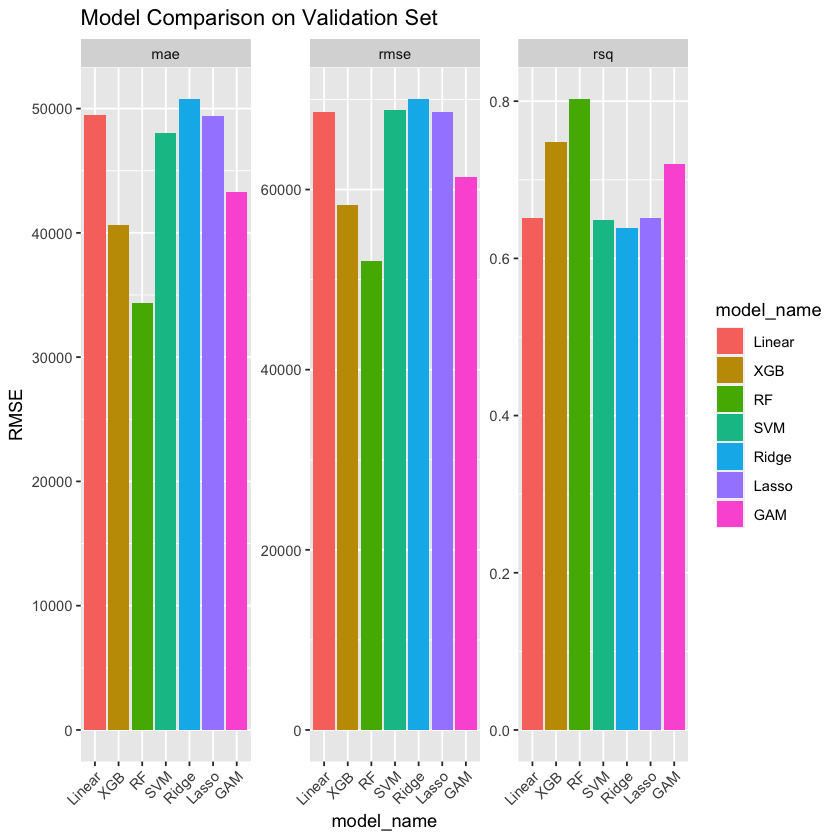

In [33]:
# Plot validation set comparison
ggplot(all_model_metrics, aes(x = model_name, y = .estimate, fill = model_name)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(y = "RMSE", title = "Model Comparison on Validation Set") +
  facet_wrap(~.metric, scales = "free") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

In [34]:
# Selecting the top two models based on validation metrics
top_models <- all_model_metrics %>%
  filter(.metric == "rmse") %>%
  group_by(model_name) %>%
  summarize(mean_rmse = mean(.estimate, na.rm = TRUE), 
            .groups = 'drop') %>%
  arrange(mean_rmse) %>%
  slice_head(n = 2)

# Print the top models
print(paste(
    "The top two models based on RMSE are:",
    paste(top_models$model_name, "with RMSE of", 
          sprintf("%.2f", top_models$mean_rmse), 
          sep=" ", 
          collapse="; "),
    sep=" "))

[1] "The top two models based on RMSE are: RF with RMSE of 52022.48; XGB with RMSE of 58273.60"


# Test Set Evaluation

In [42]:
# Fit the best Random Forest model on the training data
final_rf_fit <- fit(final_rf_wf, data = train_data)

# Fit the best XGBoost model on the training data
final_xgb_fit <- fit(final_xgb_wf, data = train_data)

In [43]:
# Evaluating Random Forest on the test set
rf_test_metrics <- predict(final_rf_fit, new_data = test_data) %>%
  bind_cols(test_data) %>%
  metrics(truth = median_house_value, estimate = .pred)

# Evaluating XGBoost on the test set
xgb_test_metrics <- predict(final_xgb_fit, new_data = test_data) %>%
  bind_cols(test_data) %>%
  metrics(truth = median_house_value, estimate = .pred)

In [44]:
# Add model names to the test metrics
rf_test_metrics <- rf_test_metrics %>%
  mutate(model_name = "Random Forest")

xgb_test_metrics <- xgb_test_metrics %>%
  mutate(model_name = "XGBoost")

In [45]:
# Combining test metrics
test_metrics <- bind_rows(
  rf_test_metrics,
  xgb_test_metrics,
  .id = "model_id"
)

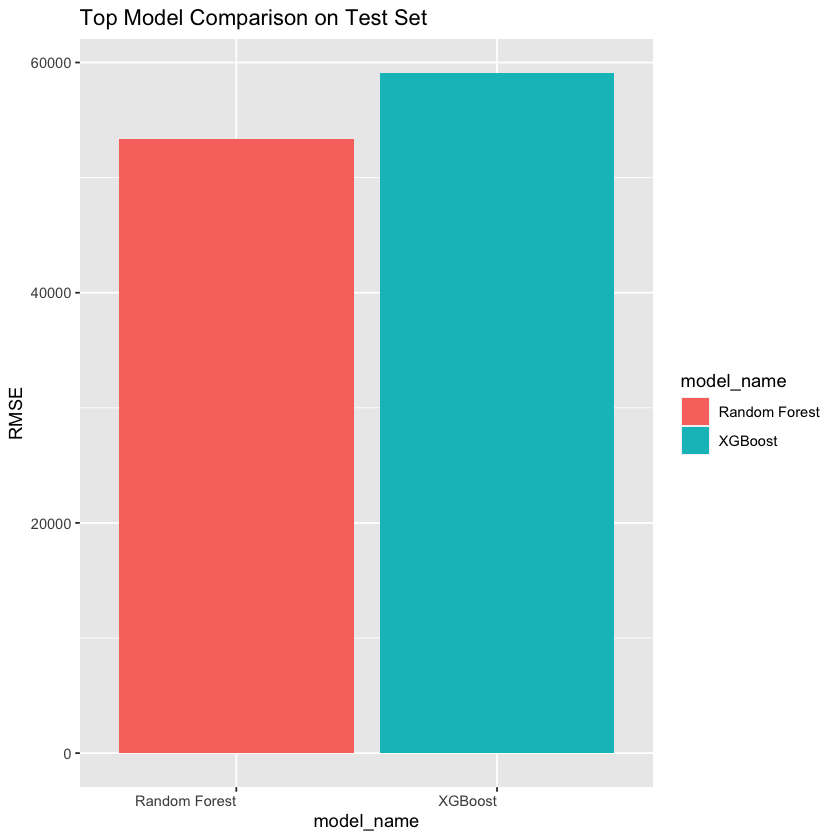

In [46]:
# Plotting test set comparison
ggplot(test_metrics, aes(x = model_name, y = .estimate, fill = model_name)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(y = "RMSE", title = "Top Model Comparison on Test Set") +
  theme(axis.text.x = element_text(angle = 0, hjust = 1))

# Conformal Prediction

In [47]:
# View best random forest workflow
final_rf_wf

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: rand_forest()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_normalize()
• step_dummy()

── Model ───────────────────────────────────────────────────────────────────────
Random Forest Model Specification (regression)

Main Arguments:
  mtry = 4
  trees = 597
  min_n = 2

Computational engine: ranger 


In [48]:
# Train the model
final_rf_wf <- final_rf_wf %>%
  fit(train_data)

In [49]:
# Calibrate the model
calib_predictions <- predict(final_rf_wf, val_data)$.pred
calib_errors <- abs(calib_predictions - val_data$median_house_value)

alpha <- 0.05 # For 95% prediction intervals
calib_threshold <- quantile(calib_errors, 1 - alpha)

In [50]:
# Make predictions
test_predictions <- predict(final_rf_wf, test_data)$.pred
prediction_intervals <- tibble(
  Lower = test_predictions - calib_threshold,
  Upper = test_predictions + calib_threshold
)

In [51]:
# Check the coverage
coverage <- mean(test_data$median_house_value >= prediction_intervals$Lower & 
                 test_data$median_house_value <= prediction_intervals$Upper)
print(coverage)

[1] 0.950194


In [52]:
# Visualization data setup
visualization_data <- test_data %>%
  mutate(
    Predicted = test_predictions,
    Lower = prediction_intervals$Lower,
    Upper = prediction_intervals$Upper
  )

visualization_data <- visualization_data %>%
  mutate(Within_Interval = median_house_value >= Lower & median_house_value <= Upper)

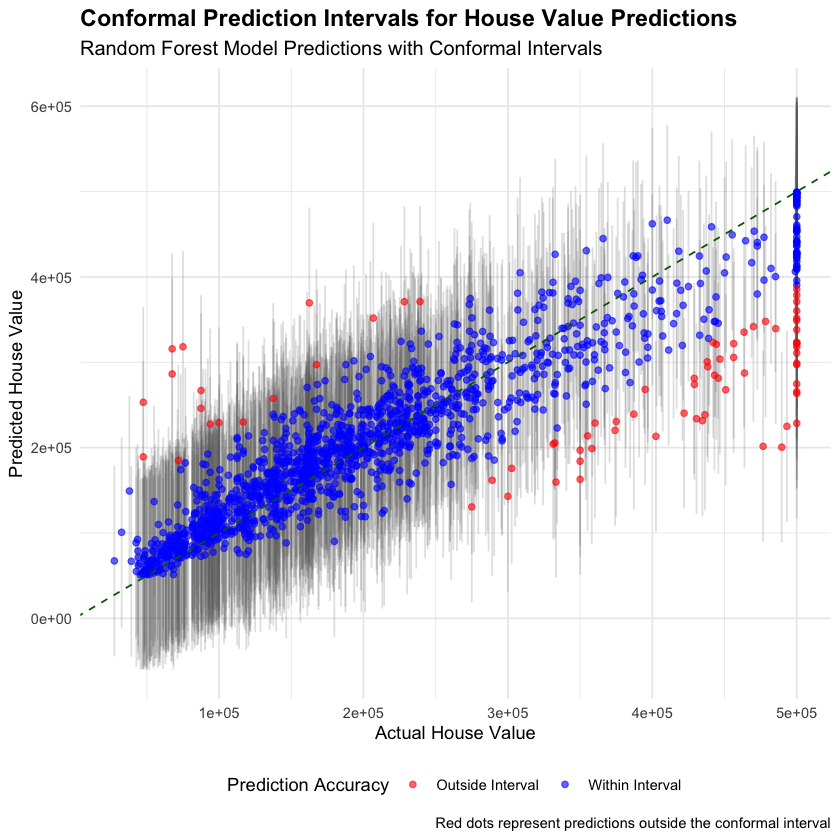

In [53]:
# Create the plot
ggplot(visualization_data, aes(x = median_house_value, y = Predicted)) +
  # Draw error bars first with lighter color and reduced width
  geom_errorbar(aes(ymin = Lower, ymax = Upper), width = 0.1, alpha = 0.2, color = "gray40") +
  # Draw points on top of error bars
  geom_point(aes(color = Within_Interval), alpha = 0.6) +
  # Color scale for points
  scale_color_manual(values = c("red", "blue"), 
                     labels = c("Outside Interval", "Within Interval"),
                     name = "Prediction Accuracy") +
  # Add a reference line
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "darkgreen") +
  # Labels and title
  labs(
    x = "Actual House Value",
    y = "Predicted House Value",
    title = "Conformal Prediction Intervals for House Value Predictions",
    subtitle = "Random Forest Model Predictions with Conformal Intervals",
    caption = "Red dots represent predictions outside the conformal interval"
  ) +
  # Minimal theme
  theme_minimal() +
  # Custom theme adjustments
  theme(
    legend.position = "bottom",
    plot.title = element_text(size = 14, face = "bold"),
    plot.subtitle = element_text(size = 12),
    # Bring the points to the front
    legend.background = element_rect(fill = "white", colour = "white")
  )

# Quantile Regression

In [54]:
# Packages
library(quantregForest)

Loading required package: RColorBrewer



In [55]:
# Extract the model and preprocessor
best_rf_model <- pull_workflow_fit(final_rf_wf)
best_rf_preprocessor <- pull_workflow_preprocessor(final_rf_wf)

Warning message:
“`pull_workflow_preprocessor()` was deprecated in workflows 0.2.3.
ℹ Please use `extract_preprocessor()` instead.”


In [56]:
# Prep the recipe with the training data
best_rf_preprocessor <- prep(best_rf_preprocessor, training = train_data)

# Prepare the training data
train_data_prepped <- bake(best_rf_preprocessor, new_data = train_data)

In [57]:
# Fit the quantile regression forest model
qrf_model <- quantregForest(x = subset(train_data_prepped, select = -median_house_value),
                            y = train_data_prepped$median_house_value)

In [58]:
# Prepare the validation and test data
val_data_prepped <- bake(best_rf_preprocessor, new_data = val_data)
test_data_prepped <- bake(best_rf_preprocessor, new_data = test_data)

In [59]:
# Predict for the quantiles with validation set
val_predictions <- predict(qrf_model, newdata = val_data_prepped, quantiles = c(0.1, 0.5, 0.9))
head(val_predictions)

quantile= 0.1 quantile= 0.5 quantile= 0.9
[1,]  93800        132600        181400       
[2,]  83400        122500        187500       
[3,]  96200        123750        159200       
[4,] 112190        208000        267020       
[5,]  99940        140000        182300       
[6,]  87500        137500        281300

In [60]:
# Predict for the quantiles with test set
test_predictions <- predict(qrf_model, newdata = test_data_prepped, quantiles = c(0.1, 0.5, 0.9))
head(test_predictions)

quantile= 0.1 quantile= 0.5 quantile= 0.9
[1,]  84270        104500        142300       
[2,]  80300         97200        150800       
[3,] 181750        315200        500001       
[4,]  75000         95950        148110       
[5,] 217100        296400        378330       
[6,] 253720        350000        500001

In [61]:
# Add predictions to validation set
val_data_prepped$Pred_10th <- val_predictions[, 1]
val_data_prepped$Pred_50th <- val_predictions[, 2]
val_data_prepped$Pred_90th <- val_predictions[, 3]

# Add predictions to test set
test_data_prepped$Pred_10th <- test_predictions[, 1]
test_data_prepped$Pred_50th <- test_predictions[, 2]
test_data_prepped$Pred_90th <- test_predictions[, 3]

In [62]:
# Aggregate predictions by actual median house value
agg_data_val <- val_data_prepped %>%
  group_by(median_house_value) %>%
  summarise(
    Pred_10th = mean(Pred_10th),
    Pred_50th = mean(Pred_50th),
    Pred_90th = mean(Pred_90th),
    .groups = 'drop'
  ) %>%
  arrange(median_house_value)

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


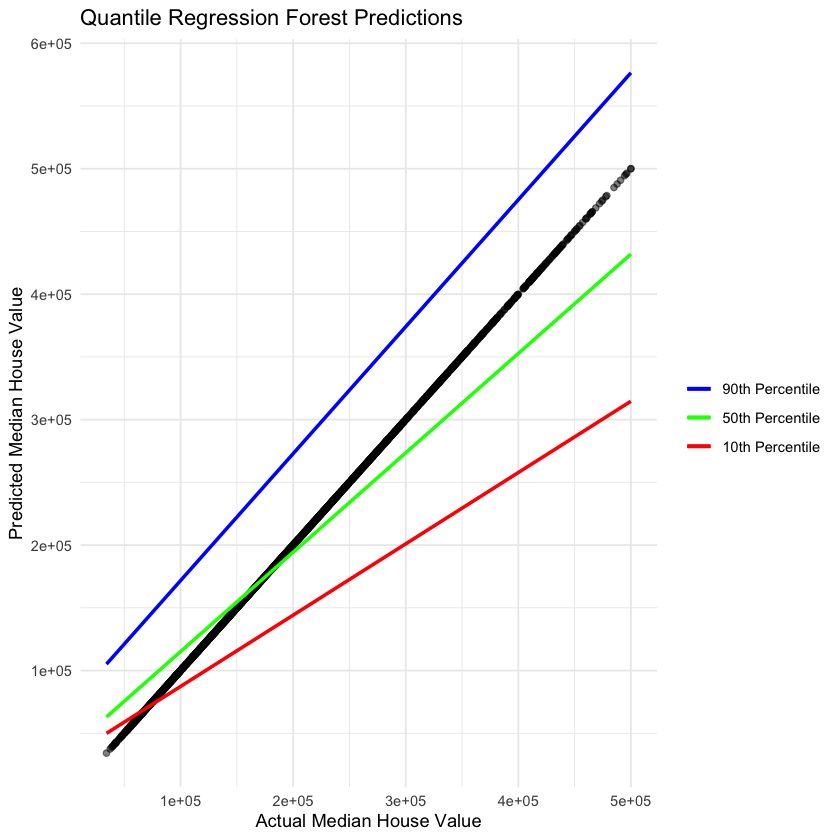

In [63]:
# Plot using the aggregated data
p <- ggplot(agg_data_val, aes(x = median_house_value)) +
  geom_point(aes(y = median_house_value), color = "black", alpha = 0.5) +
  geom_smooth(aes(y = Pred_10th, color = "10th Percentile"), method = "lm", se = FALSE) +
  geom_smooth(aes(y = Pred_50th, color = "50th Percentile"), method = "lm", se = FALSE) +
  geom_smooth(aes(y = Pred_90th, color = "90th Percentile"), method = "lm", se = FALSE) +
  scale_color_manual(
    values = c("10th Percentile" = "red", "50th Percentile" = "green", "90th Percentile" = "blue"),
    limits = c("90th Percentile", "50th Percentile", "10th Percentile")
  ) +
  labs(title = "Quantile Regression Forest Predictions",
       x = "Actual Median House Value",
       y = "Predicted Median House Value") +
  theme_minimal() +
  theme(legend.title = element_blank())

# Print the plot
print(p)

In [64]:
# Aggregate predictions by actual median house value
agg_data_test <- test_data_prepped %>%
  group_by(median_house_value) %>%
  summarise(
    Pred_10th = mean(Pred_10th),
    Pred_50th = mean(Pred_50th),
    Pred_90th = mean(Pred_90th),
    .groups = 'drop'
  ) %>%
  arrange(median_house_value)

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


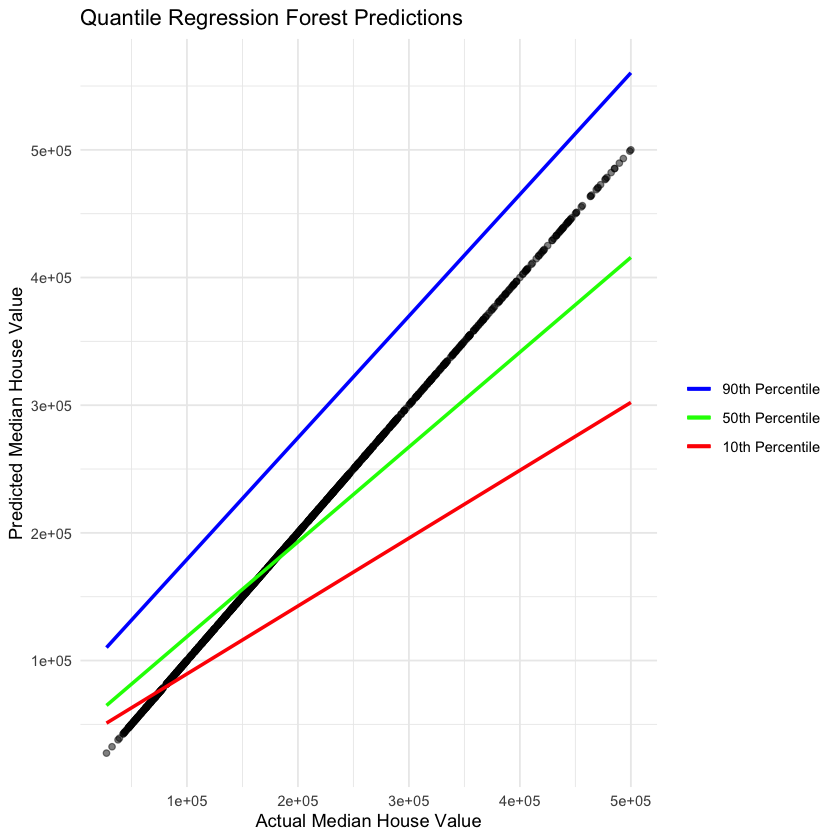

In [65]:
# Plot using the aggregated data
p <- ggplot(agg_data_test, aes(x = median_house_value)) +
  geom_point(aes(y = median_house_value), color = "black", alpha = 0.5) +
  geom_smooth(aes(y = Pred_10th, color = "10th Percentile"), method = "lm", se = FALSE) +
  geom_smooth(aes(y = Pred_50th, color = "50th Percentile"), method = "lm", se = FALSE) +
  geom_smooth(aes(y = Pred_90th, color = "90th Percentile"), method = "lm", se = FALSE) +
  scale_color_manual(
    values = c("10th Percentile" = "red", "50th Percentile" = "green", "90th Percentile" = "blue"),
    limits = c("90th Percentile", "50th Percentile", "10th Percentile")
  ) +
  labs(title = "Quantile Regression Forest Predictions",
       x = "Actual Median House Value",
       y = "Predicted Median House Value") +
  theme_minimal() +
  theme(legend.title = element_blank())

# Print the plot
print(p)

In [66]:
# Function to create aggregated data and plot
create_plot <- function(data, title_suffix) {
  agg_data <- data %>%
    group_by(median_house_value) %>%
    summarise(
      Pred_10th = mean(Pred_10th),
      Pred_50th = mean(Pred_50th),
      Pred_90th = mean(Pred_90th),
      .groups = 'drop'
    ) %>%
    arrange(median_house_value)
  
  p <- ggplot(agg_data, aes(x = median_house_value)) +
    geom_point(aes(y = median_house_value), color = "black", alpha = 0.5) +
    geom_smooth(aes(y = Pred_10th, color = "10th Percentile"), method = "lm", se = FALSE) +
    geom_smooth(aes(y = Pred_50th, color = "50th Percentile"), method = "lm", se = FALSE) +
    geom_smooth(aes(y = Pred_90th, color = "90th Percentile"), method = "lm", se = FALSE) +
    scale_color_manual(
      values = c("10th Percentile" = "red", "50th Percentile" = "green", "90th Percentile" = "blue"),
      limits = c("90th Percentile", "50th Percentile", "10th Percentile")
    ) +
    labs(title = paste("Quantile Regression Forest Predictions", title_suffix),
         x = "Actual Median House Value",
         y = "Predicted Median House Value") +
    theme_minimal() +
    theme(legend.title = element_blank())
  
  return(p)
}

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


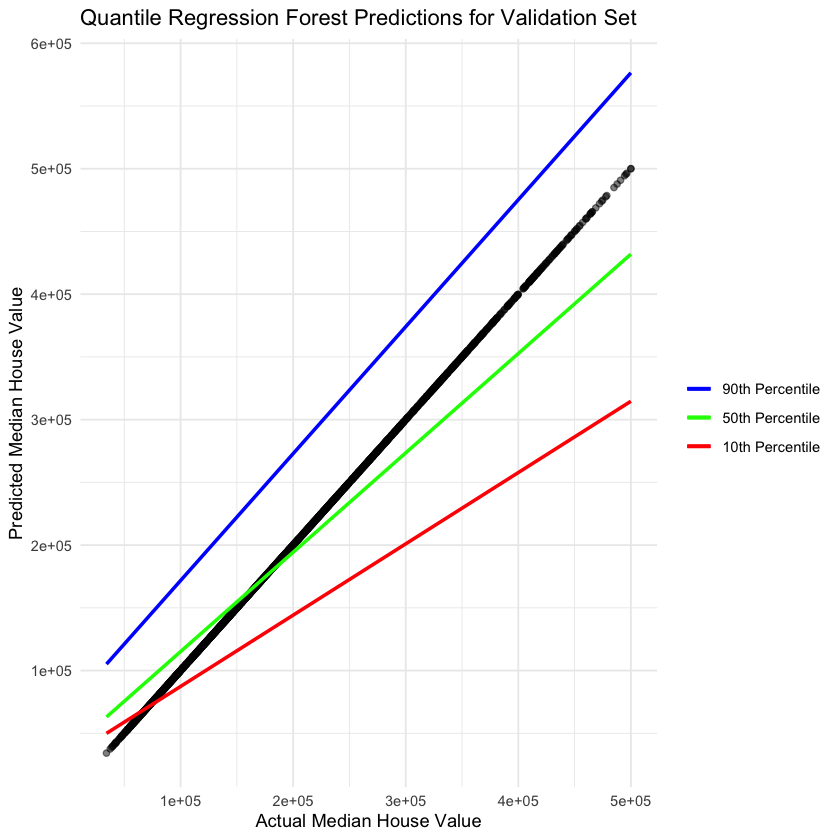

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


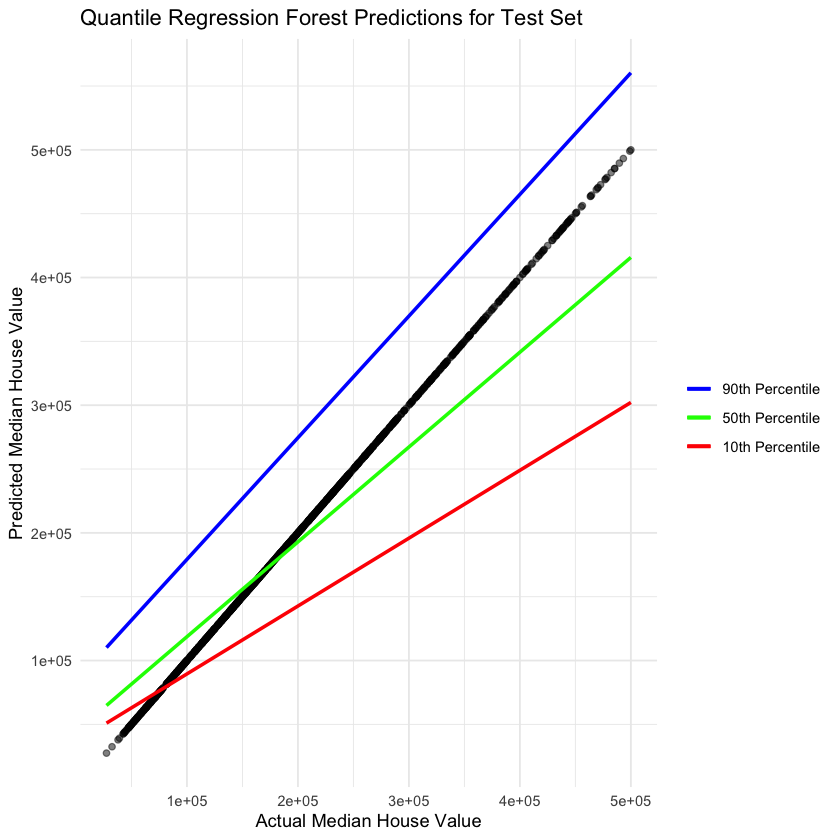

In [67]:
# Create and print plots
val_plot <- create_plot(val_data_prepped, "for Validation Set")
test_plot <- create_plot(test_data_prepped, "for Test Set")

print(val_plot)
print(test_plot)

# Save the plots
ggsave("val_plot.png", val_plot, width = 10, height = 6)
ggsave("test_plot.png", test_plot, width = 10, height = 6)

In [68]:
# Packages
library(patchwork)

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


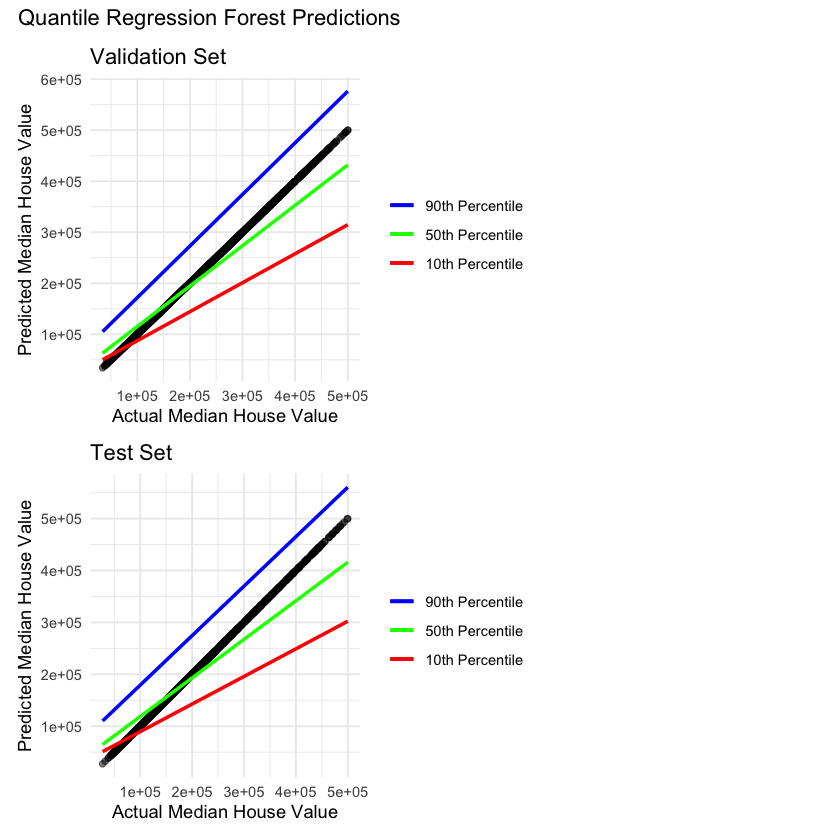

In [69]:
# Assign titles to each plot
val_plot <- val_plot + ggtitle("Validation Set")
test_plot <- test_plot + ggtitle("Test Set")

# Combine the plots with a spacer between them
combined_plot_layout <- val_plot + plot_spacer() + test_plot

# Adjust the layout to have two columns and one row
combined_plot_layout <- combined_plot_layout + 
  plot_layout(ncol = 2) + 
  plot_annotation(title = "Quantile Regression Forest Predictions")

# Print the combined plot with spacing
combined_plot_layout

# Save the combined plot
ggsave("combined_plots.png", combined_plot_layout, width = 20, height = 6)